# Nonadiabatic Dynamics for Systems Interacting with Bath.

## Table of content <a name="TOC"></a>

1. [Define the model Hamiltonian](#model_hamiltonian)  
      
2. [Model analysis](#model_analysis)  

3. [Dynamics](#dynamics)  

  3.1. [Regular FSSH - in the NVE ensemble](#fssh)
  
  3.2. [FSSH in the NVT ensemble: 1 DOF is quantum + 4 DOFs thermostatted](#fssh-nvt)
    
  3.3. [FSSH in the NVT ensemble: 1 quantum DOF + 3 thermostatted DOFs + 1 DOF constrained](#fssh-nvt-constraints)
    
  3.4. [FSSH in the NVE ensemble: all DOFs are quantum](#fssh-all-quantum)
    

## A. Learning objectives

* to define the model Hamiltonians suitable for modeling NA dynamics in quantum systems interacting with classical bathes
* to plot the multidimensional PES surface profiles along arbitrary nuclear DOFs
* to execute (nonadiabatic)dynamics in the presence of thermostat
* to control which nuclear DOFs shall be treated as quantum and which as classical
* to control which nuclear DOFs shall be coupled to a thermostat
* to be able to constrain arbitrary nuclear DOFs in the dynamics


## B. Use cases

* [Plot the PES profiles with multidimensional model Hamiltonians](#pes-plot)
* [MD and NAMD in the NVT ensemble](#dyn-nvt)
* [Partitioning quantum and classical DOFs](#dyn-partition)
* [Coupling classical DOFs to thermostat](#dyn-thermostat)
* [Constraining DOFs in dynamics](#dyn-constrain)


## C. Functions

- `libra_py`
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic-recipe)
        - [`init_nuclear_dyn_var`](#init_nuclear_dyn_var)
      - `plot`
        - [`plot_dynamics`](#plot_dynamics)        
  - `dynamics_plotting` 
    - [`plot_surfaces`](#plot_surfaces)
  - `models`
    - `Tully`
        - [`chain_potential`](#chain_potential) | [Example 2](#chain_potential-2)
                  

## D. Classes and class members

- `liblibra::librandom`
  - [`Random`](#random)    
    

Import Libra and other dependencies such as numpy and matplotlib

In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

import util.libutil as comn
from libra_py import units
from libra_py import dynamics_plotting
from libra_py.models import Tully

import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot



#from matplotlib.mlab import griddata
%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

## 1. Define the model Hamiltonian <a name="model_hamiltonian"></a>
[Back to TOC](#TOC)

In this tutorial, we will work with the model Hamiltonian that describes a quantum system coupled to a 1D chain of classical particles. Well, they don't really have to be classical, as we'll see later - it is all about how we treat them in the dynamics. So, there is nothing in the construction of the model Hamiltonian that allows us to dinstinguish quantum and classical particles (or, more generally, degrees of freedom, DOFs).

Having said that, the potential is designed such that the roles of the DOFs 0 and all others are somewhat different. This is done to next say that the DOF 0 will be treated quantum-mechanically and all other DOFs - classically.

The Hamiltonian is constructed as follows:


$$
H^{dia} = \sum_{n=0}^{M-1} { |n> [ E_n + \frac{1}{2} k_n (q_0 - x_n)^2  + \sum^{N-1}_{i=0} { U (q_{i+1} - q_i )} ] <n|  } + \sum_{n,m=0}^{M-1} { |n> V_{nm}<m| }
$$

$$
U (z) = U_0 (a^2 z^2 - a^3 z^3 + 0.58 a^4 z^4)
$$

Here:

* $\{q_i\}, i = 0,...,N-1$ represents the nuclear DOFs, with $N$ being the number of nuclear DOFs
* $\{E_n, x_n, k_n\}, n = 0,...,M-1$  are the parameters that define distinct terms in $M$ diabatic surfaces (parabolas) - the minimum energy, the coordinate of the minmum, and the curvature, respectively
* $V_{nm}, n,m = 0,..., M-1$ are the diabatic couplings
* $U_0$ and $a$ are the parameters of the potential that couples the adjacent (in index) particles of the chain

Note that the numbers $M$ and $N$ do not have to be equal to each other, since they define the number of diabatic (and hence adiabatic) states and the total number of nuclear DOFs, respectively. In particular, one shall not confuse or associate the $\{x_n\}$ set which defines the shape of the diabatic/adiabatic surfaces and the $\{q_n\}$, the coordinates of all particles.

The implementation of the Hamiltonian is shown below. Also, note how we also need to define the derivatives of the matrix elements w.r.t. all nuclear DOFs - this is needed to be able to compute derivative couplings and adiabatic forces.

<a name="chain_potential"></a>

In [2]:
class tmp:
    pass

def chain_potential(q, params, full_id):
    """    
    A 1D linear chain potential

    Args: 
        q ( MATRIX(ndof,1) ): coordinates of the nuclear DOFs
        params ( dictionary ): model parameters

            * **params["A"]** ( double ): [ units: None ]
            * **params["a"]** ( double ):  [ units: bohr-1 ]
            * **params["V0]** ( double ):  [ units: Ha ]            
            * **params["E_n"]** ( list of doubles ):  [ default: [0.0, 0.001, 0.001, 0.001], units: Ha]
            * **params["x_n"]** ( list of doubles ):  [ default: [0.0, 1.0, 1.0, 1.0], units: Bohr]
            * **params["k_n"]** ( list of doubles ):  [ default: [0.001, 0.001, 0.001, 0.001], units: Ha/Bohr^2]
            * **params["V"]**   ( list of lists of double ):  [ default:  [[0.001]*4]*4, units: Ha]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
    """

    Id = Cpp2Py(full_id)
    indx = Id[-1]
    X = q.col(indx)       # coordinates of all particles for this trajectory
    ndof = q.num_of_rows  # the total number of DOFs, the first one is the quantum DOF
    
    
    critical_params = ["E_n", "x_n", "k_n" ]
    default_params = { "V": [ [0.001, 0.001, 0.001, 0.001], [0.001, 0.001, 0.001, 0.001],
                              [0.001, 0.001, 0.001, 0.001], [0.001, 0.001, 0.001, 0.001] ],
                       "a":0.25, "U0":0.06665
                     }
    comn.check_input(params, default_params, critical_params)

    # Parameters describing the diabatic PES for quantum DOF
    E_n = params["E_n"] # energies of the minima of the diabatic PESs for quantum particle
    x_n = params["x_n"] # positions of diabatic PESs
    k_n = params["k_n"] # curvatures of diabatic PESs
    V = params["V"]     # diabatic couplings
    nstates = len(E_n)  # the number of electronic states
    
    # Parameters describing classical particles and their coupling to the quantum particle    
    a  = params["a"]
    U0 = params["U0"]
    a2 =  U0*a**2
    a3 = -U0*a**3
    a4 = 0.58*U0*a**4
    
                
    Hdia = CMATRIX(nstates,nstates)
    Sdia = CMATRIX(nstates,nstates)
    Sdia.identity()
    basis_transform = CMATRIX(nstates,nstates)
    basis_transform.identity()
    
    
    d1ham_dia = CMATRIXList();
    dc1_dia   = CMATRIXList();
    for k in range(ndof):
        d1ham_dia.append( CMATRIX(nstates,nstates) )
        dc1_dia.append( CMATRIX(nstates,nstates) ) 

        
    #========= Classical (bath) contributions =========    
    H_bath  = 0.0
    dH_bath = []
    for k in range(ndof-1):
        x1 = X.get(k)
        x2 = X.get(k+1)
        d = x1 - x2
        d2 = d*d
        d3 = d2*d
        d4 = d3*d
        H_bath += (a2*d2 + a3*d3 + a4*d4)
        dH_bath.append( 2.0*a2*d + 3.0*a3*d2 + 4.0*a4*d3 )

        
    for i in range(nstates):        
        Hdia.add(i,i, H_bath*(1.0+0.0j))
                
        k = 0
        d1ham_dia[k].add(i, i, ( dH_bath[k] ) * (1.0+0.0j) )
        
        for k in range(1, ndof-1):
            d1ham_dia[k].add(i, i, ( dH_bath[k] - dH_bath[k-1] ) * (1.0+0.0j) )
            
        k = ndof - 1
        d1ham_dia[k].add(i, i, ( -dH_bath[k-1] ) * (1.0+0.0j) )
        
    
        
    """
    for k in range(1, ndof):        
        
        d = (X.get(0) - X.get(k) )        
        d2 = d*d        
        H_bath = 0.5 * U0*d2
        dH_bath = U0 * d
        
        
        for i in range(nstates):        
            Hdia.add(i,i, H_bath*(1.0+0.0j) )            
            d1ham_dia[k].add(i, i, ( -dH_bath ) * (1.0+0.0j) )
            d1ham_dia[0].add(i, i, (  dH_bath ) * (1.0+0.0j) )
        
    """
        
    #========== Quantum system ==================    
    x = X.get(0)    
    for i in range(nstates):        
        # Energies
        Hdia.add(i,i,  (E_n[i] + 0.5*k_n[i]*(x - x_n[i])**2) * (1.0+0.0j) )
                
        for j in range(nstates):
            if i!=j:
                Hdia.add(i,j,  V[i][j] * (1.0+0.0j) )
        
        # Derivatives
        k = 0 # quantum DOF
        d1ham_dia[k].add(i,i, (k_n[i] * (x - x_n[i]))*(1.0+0.0j) )

                        
    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.dc1_dia = dc1_dia
    #obj.basis_transform = basis_transform
    
    return obj


This function is also defined in `libra_py.models.Tully` module of Libra

Let us define a wrapper `compute_model` function, to be able to easily change the model used in multiple calculations, although in this case we have only 1 such model.

In [3]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:        
        res = chain_potential(q, params, full_id)
    
    return res


## 2. Analysis of the model <a name="model_analysis"></a>
[Back to TOC](#TOC)

In this tutorial, we will be looking at the nonadiabatic dynamics in a 3-state systems with 5 nuclear DOFs. 

To facilitate the selection of the initial conditions and the analysis of the dynamics, lets visualize the diabatic and adiabatic PES for this model, as well as the projections of the adiabatic states on the diabatic ones for range of coordinates of interest.

In this example, we also show the extra-parameters the `plot_surfaces` function can take, namely:

* `ndof` - the total number of nuclear DOFs for the model Hamiltonian of interest;
* `scan_coord` - the index of the nuclear DOF (coordinate) along which the scan is executed. By controlling this variable we can look at the profiles of the PES along different coordiantes.
* `all_coords` - when we scan one variable, we need to fix all other coordinates to some values. This is what this list does. Also, it shall be the length `ndof`

In this example we show the PES profiles along the "to-be-quantum" DOF.

<a name="plot_surfaces"></a><a name="pes-plot"></a>

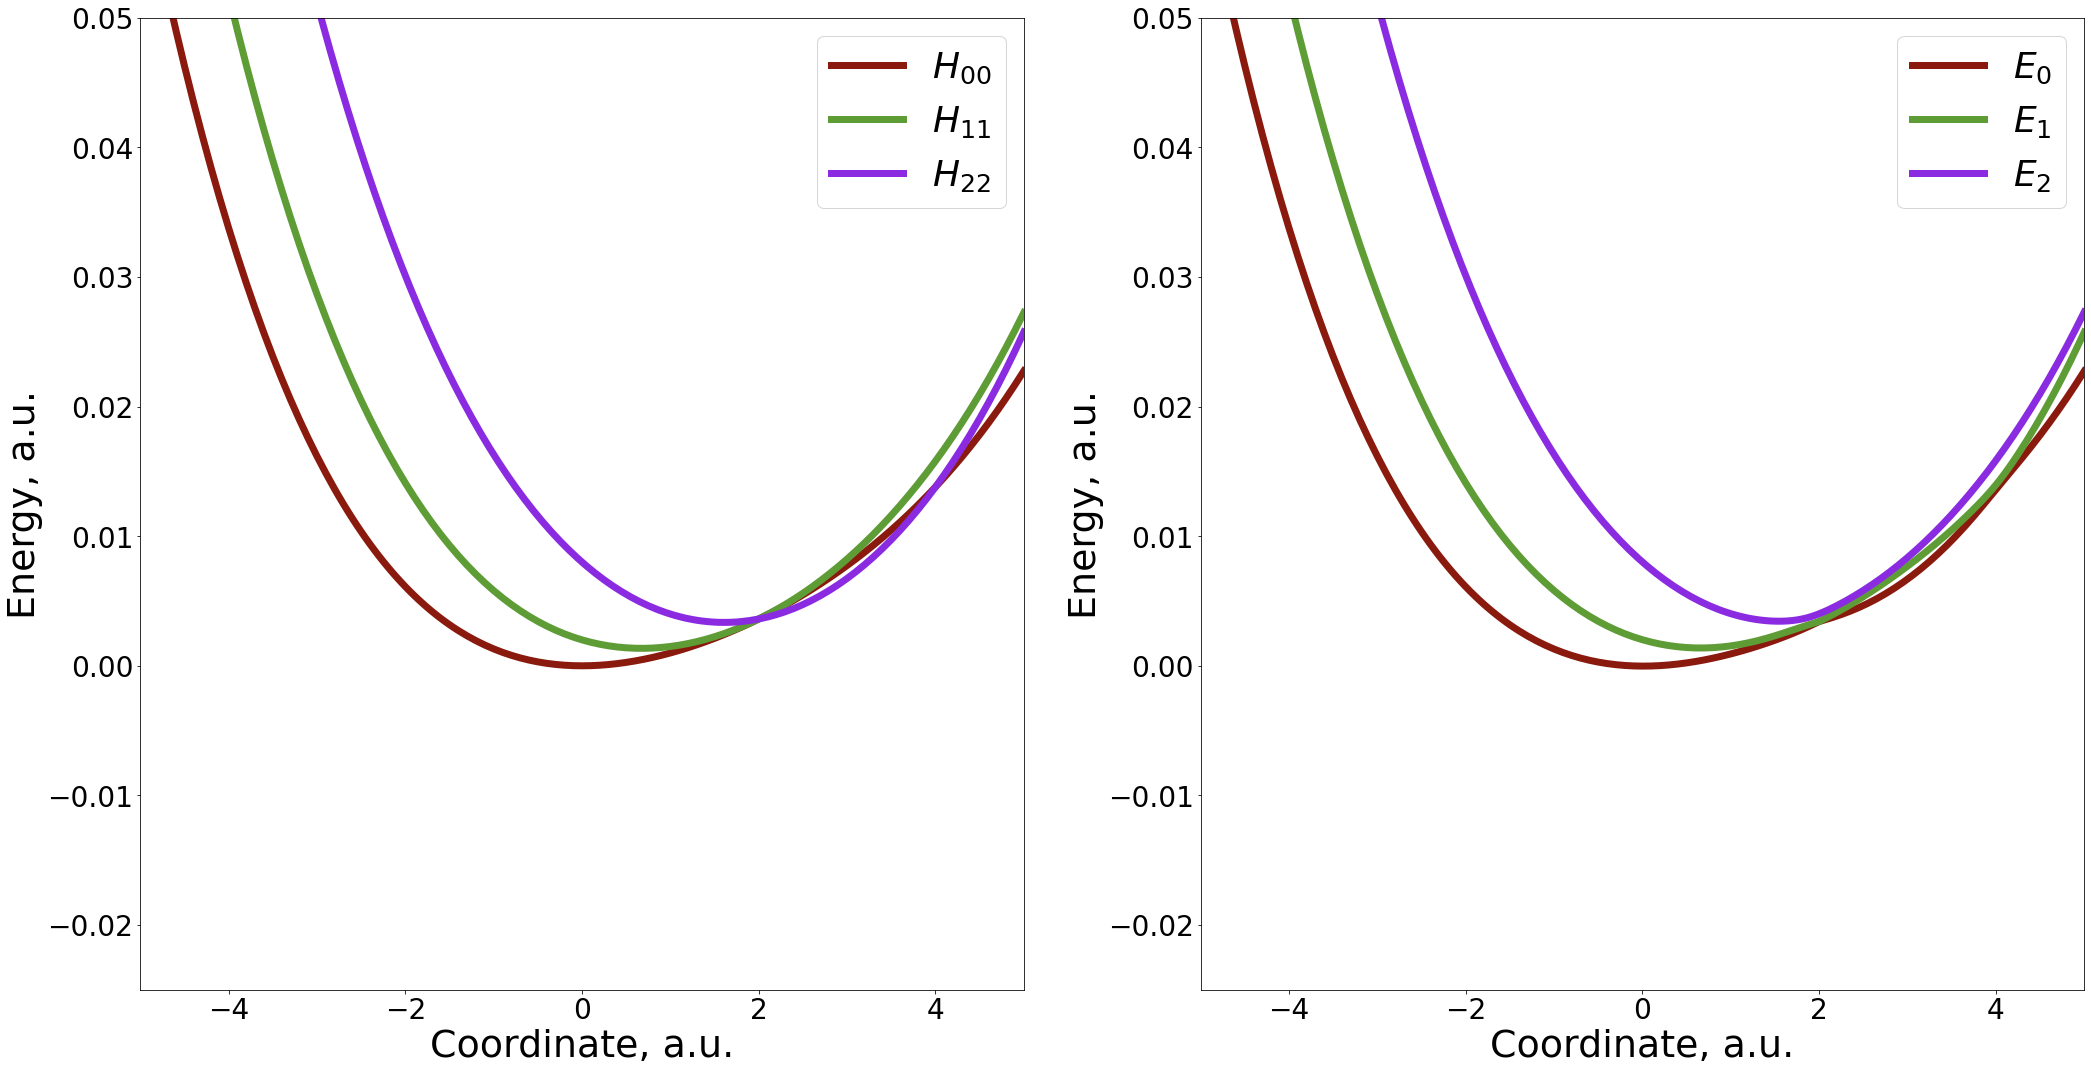

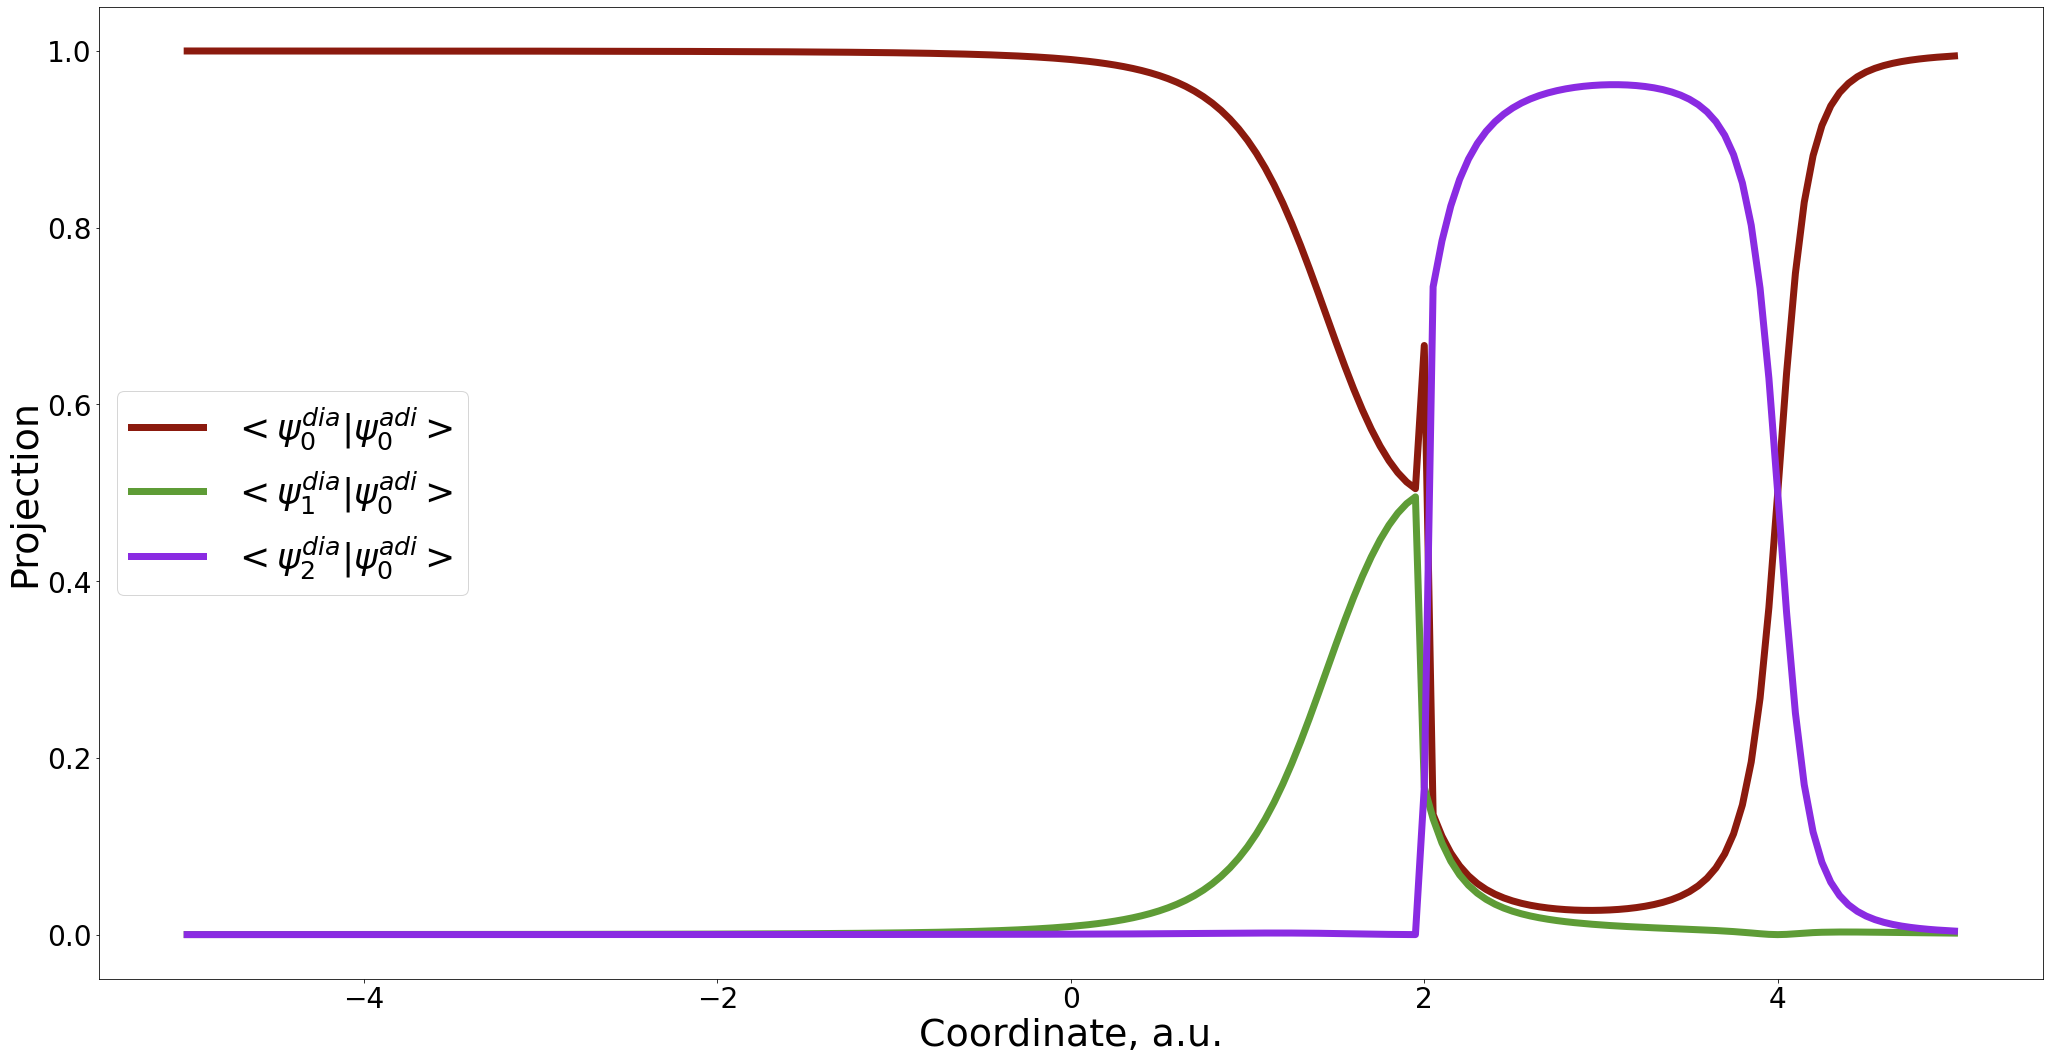

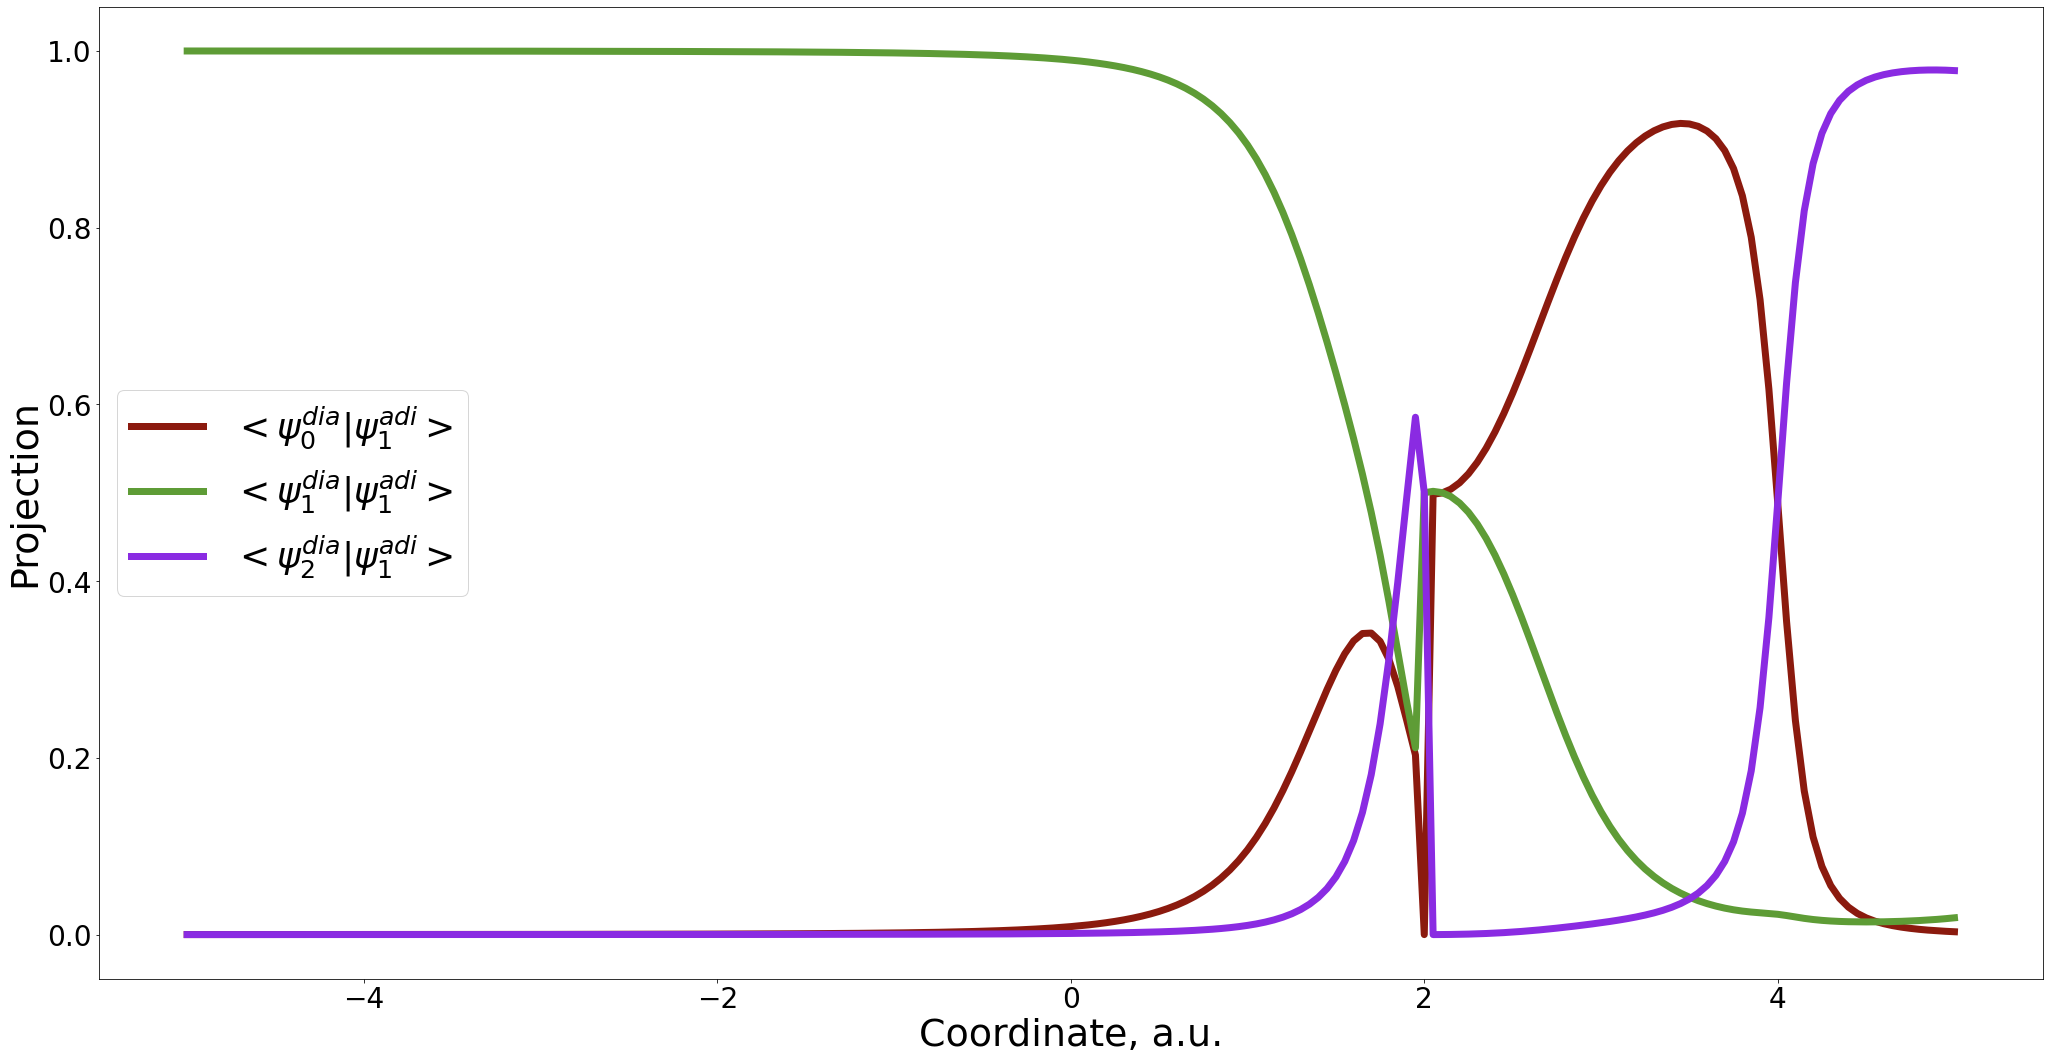

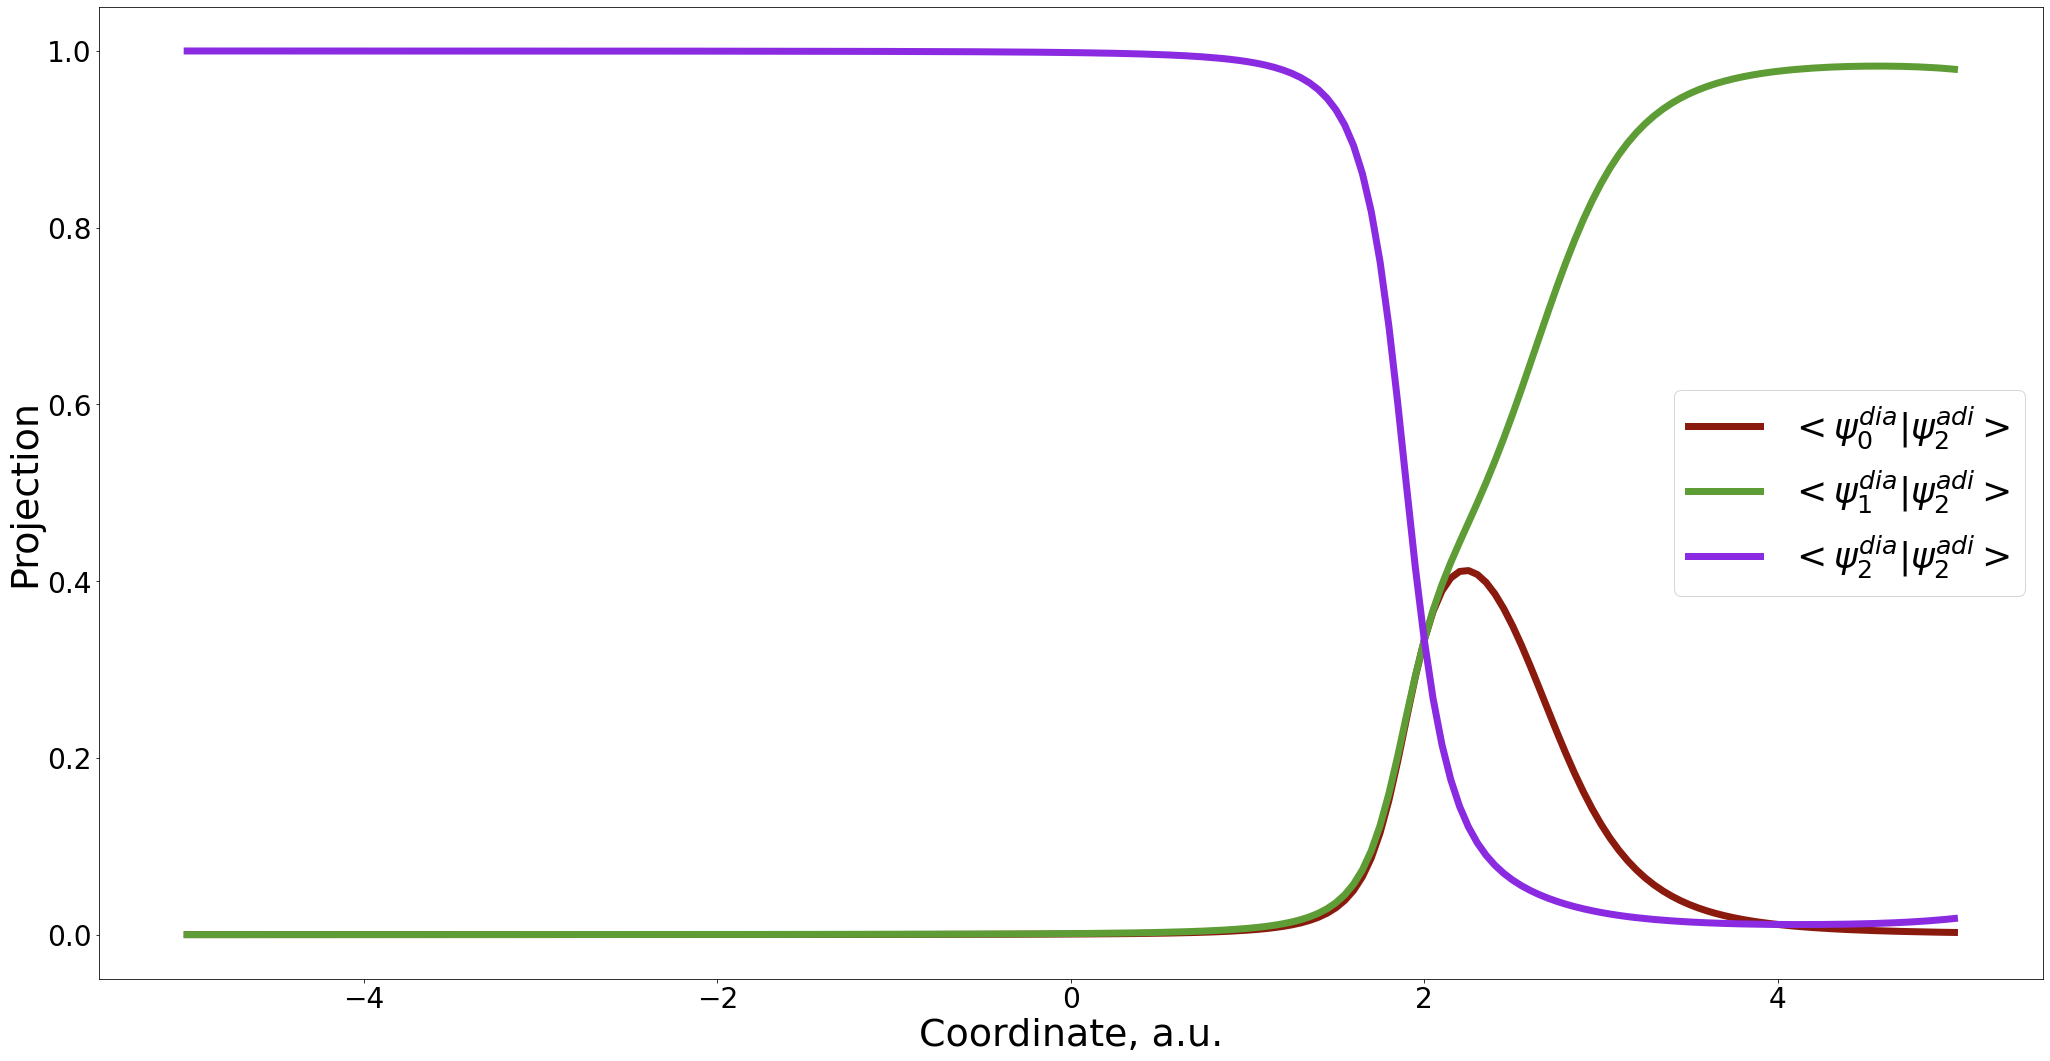

In [4]:
couplings = [  [ 0.0000, 0.0002, 0.0002 ],
               [ 0.0002, 0.0000, 0.0002 ],
               [ 0.0002, 0.0002, 0.0000 ] 
            ]
model_params = {"model":1,
                "E_n":[0.0, 0.001, 0.002],
                "x_n":[0.0, 1.0, 2.0],
                "k_n":[0.001, 0.002, 0.003],
                "V":couplings,
                "U0":0.01,
                "nstates":3 }

plot_params = {"colors": colors, "clrs_index": clrs_index, "ylim":[-0.025, 0.05], "xlim":[-5.0, 5.0] }

all_coords = [0.0, 0.0, 0.0, 0.0, 0.0]
ndof = len(all_coords)
scan_coord = 0
dynamics_plotting.plot_surfaces(compute_model, [ model_params ], [0,1,2], -5, 5.0, 0.05, 
                                plot_params, ndof, scan_coord, all_coords)

Now, lets look a the PES profiles along one of the classical DOFs
<a name="chain_potential-2"></a>

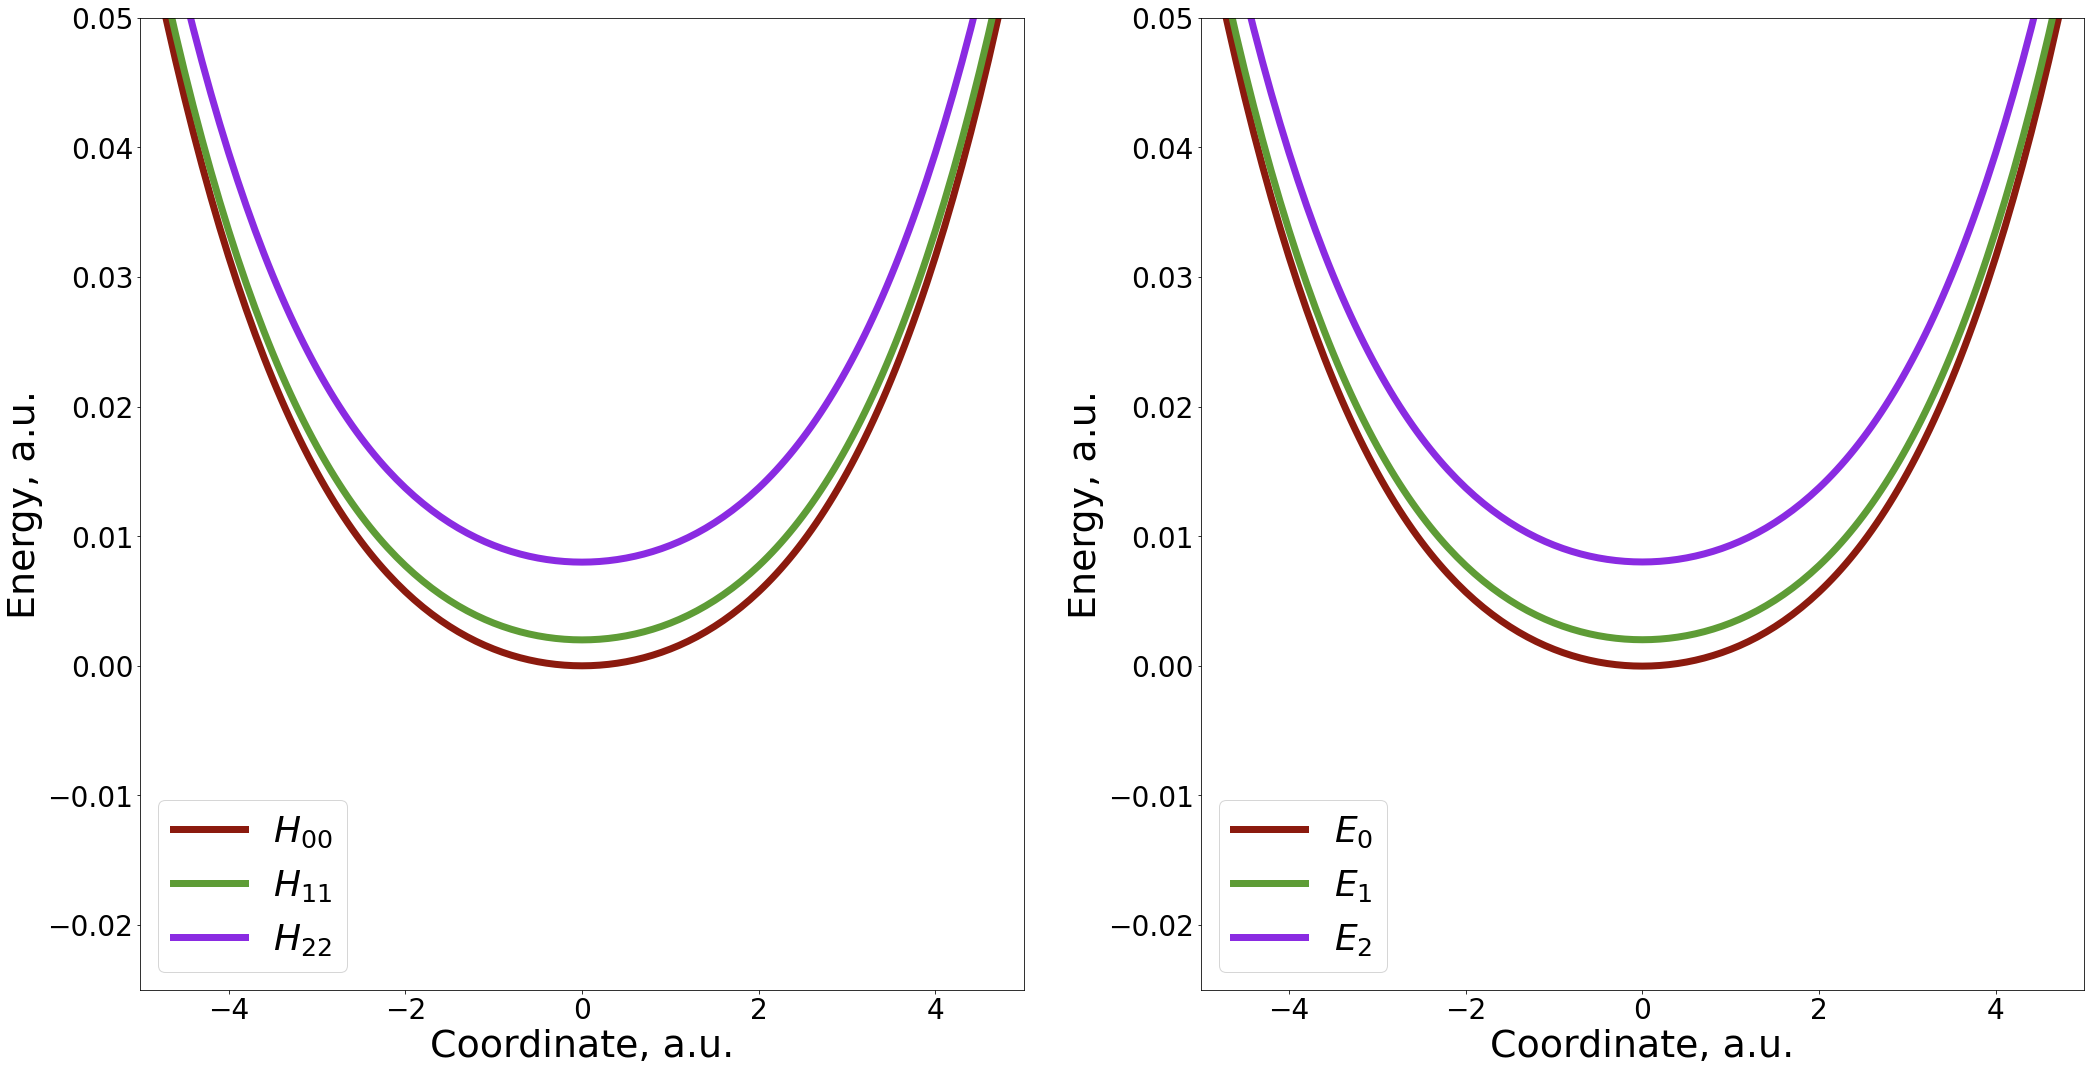

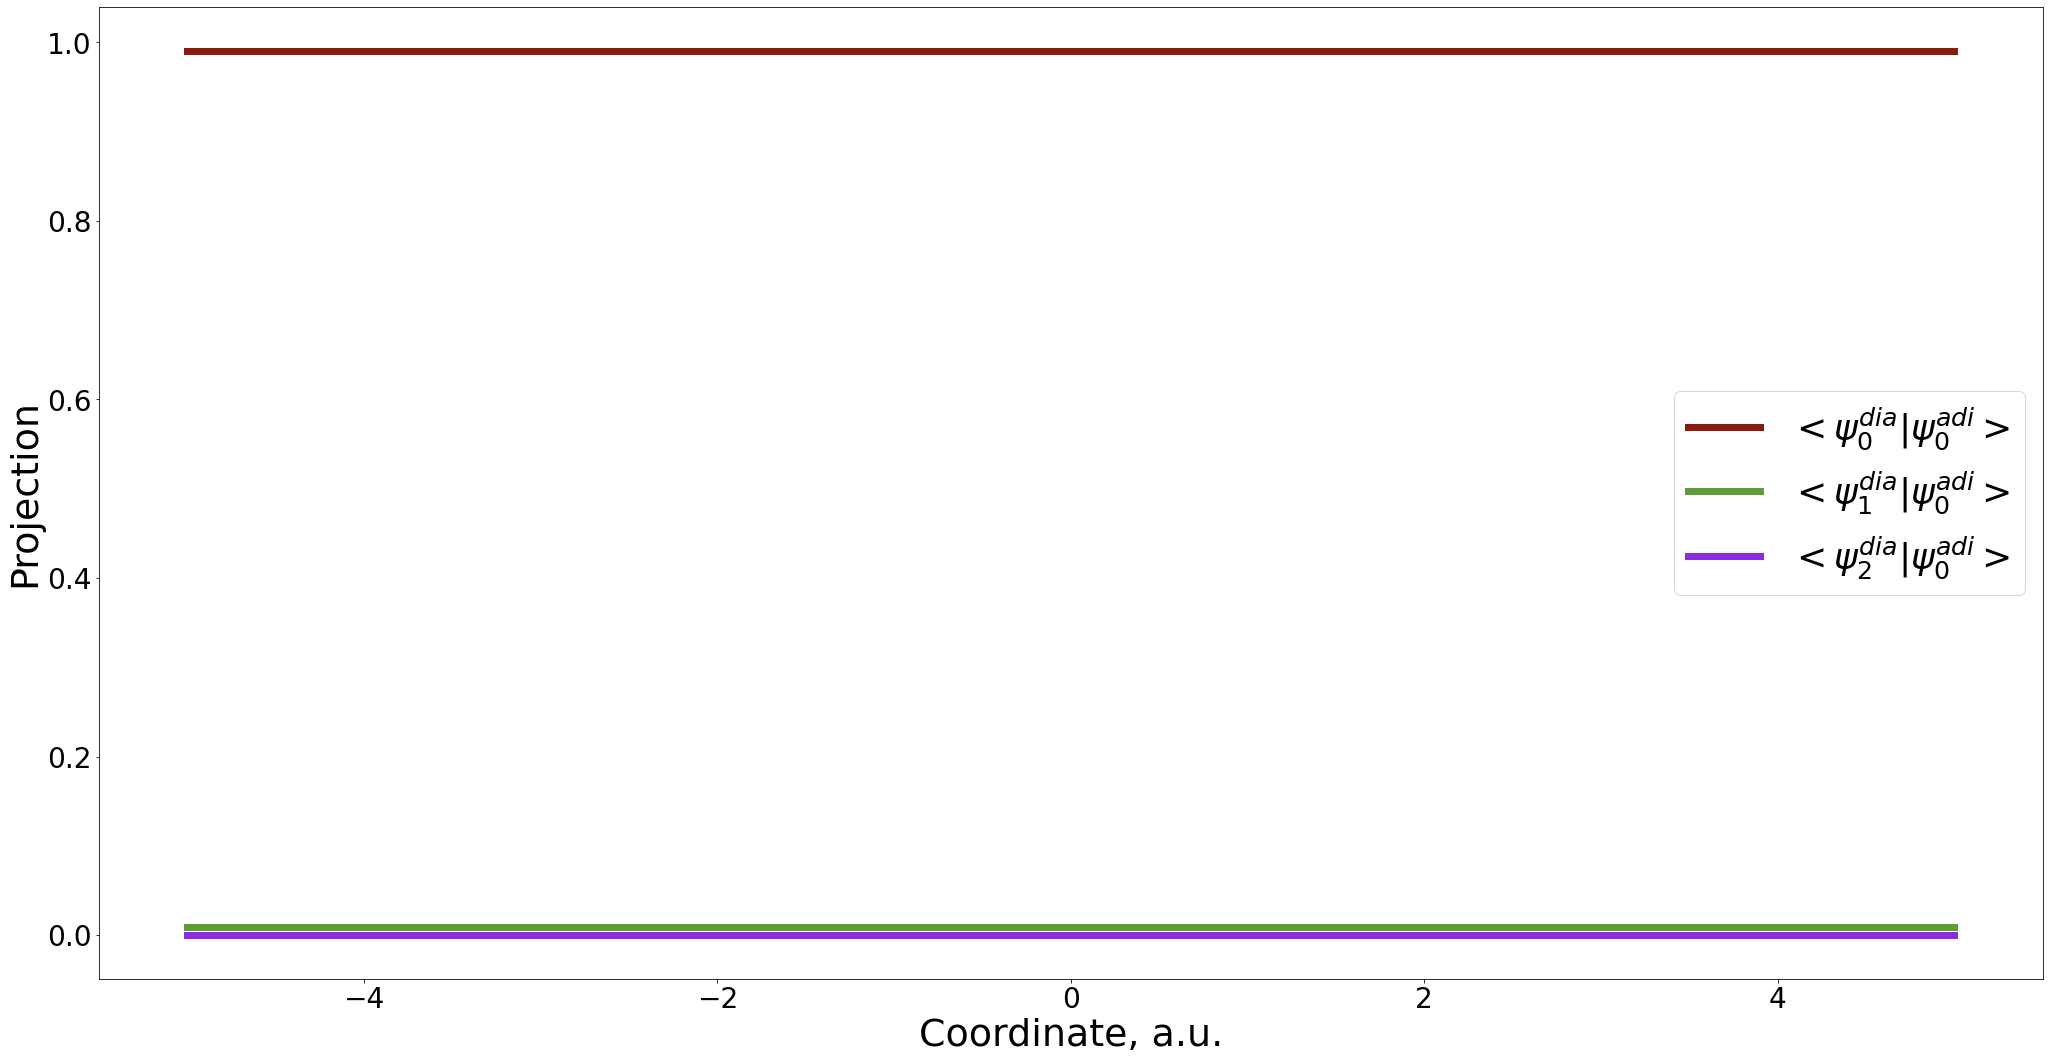

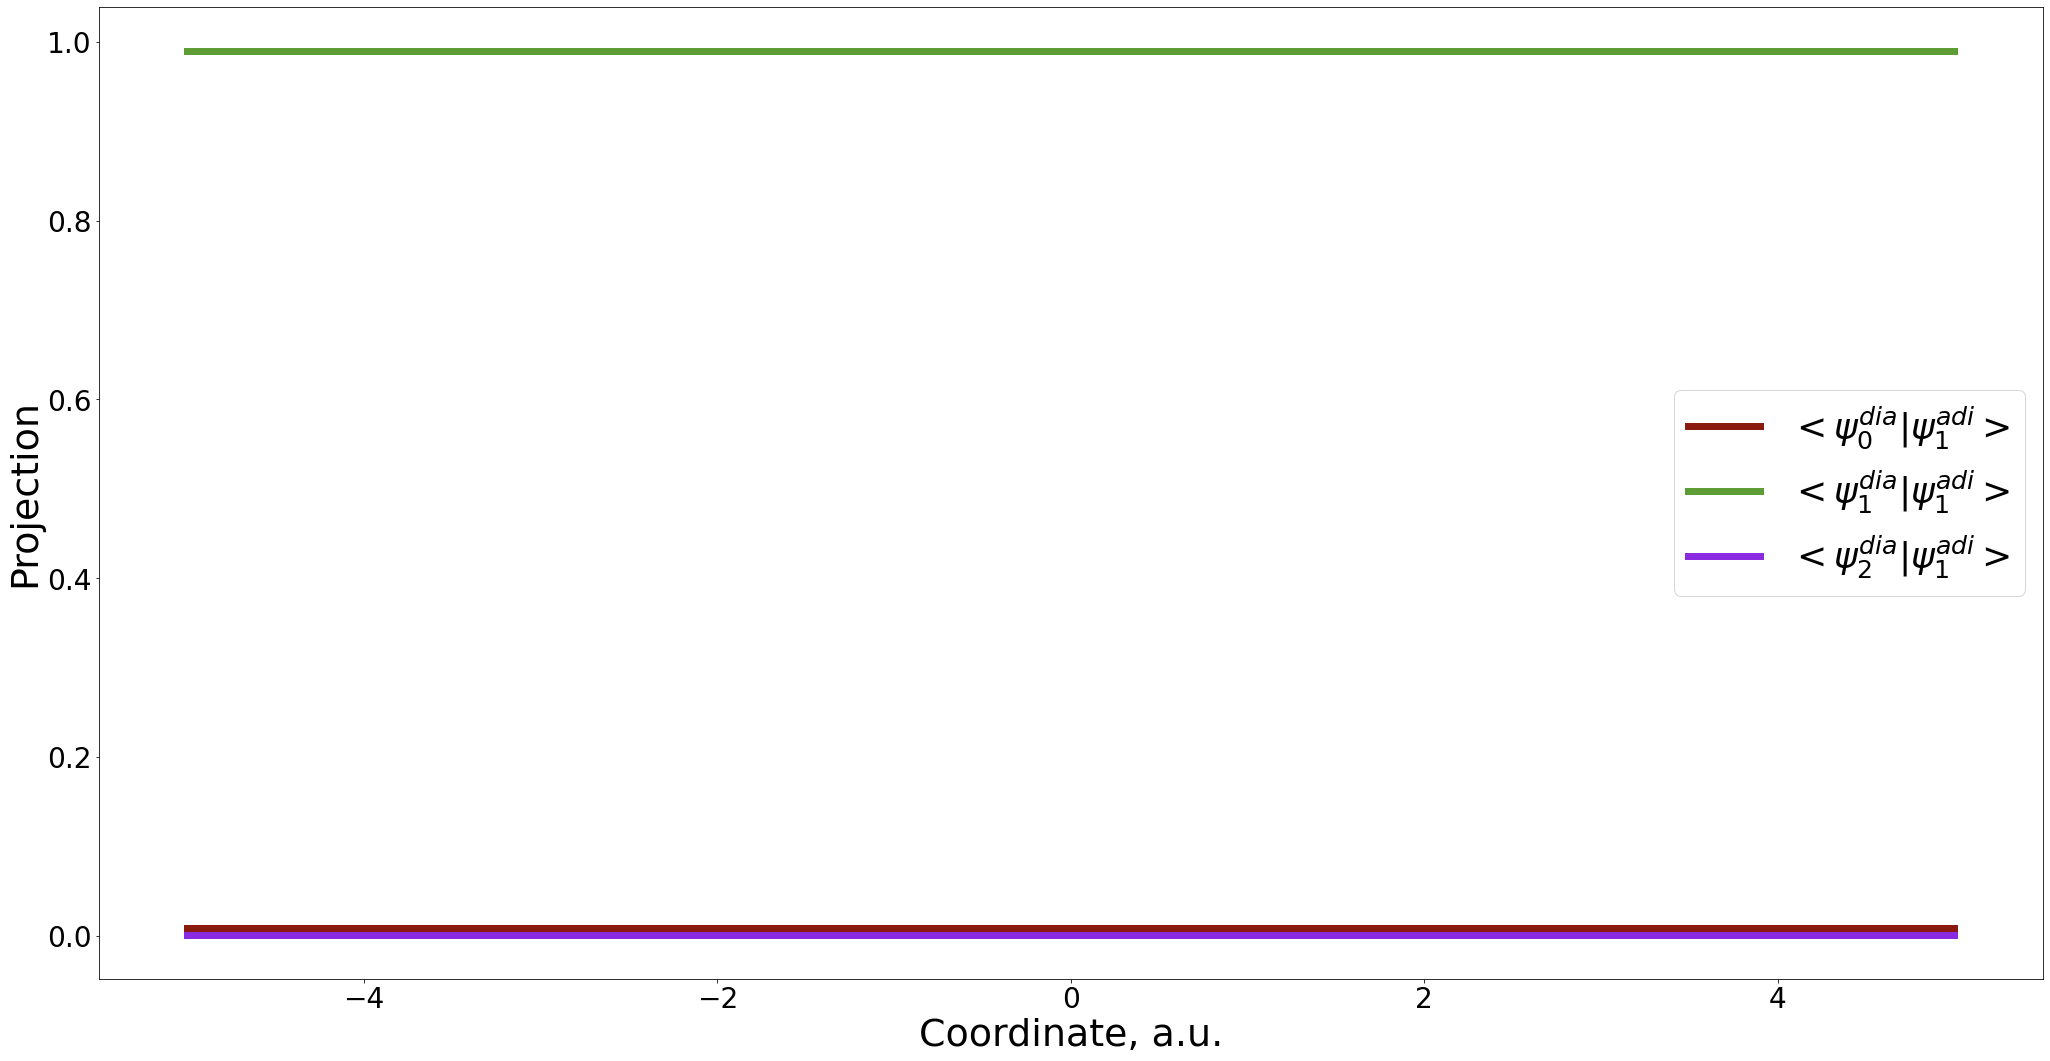

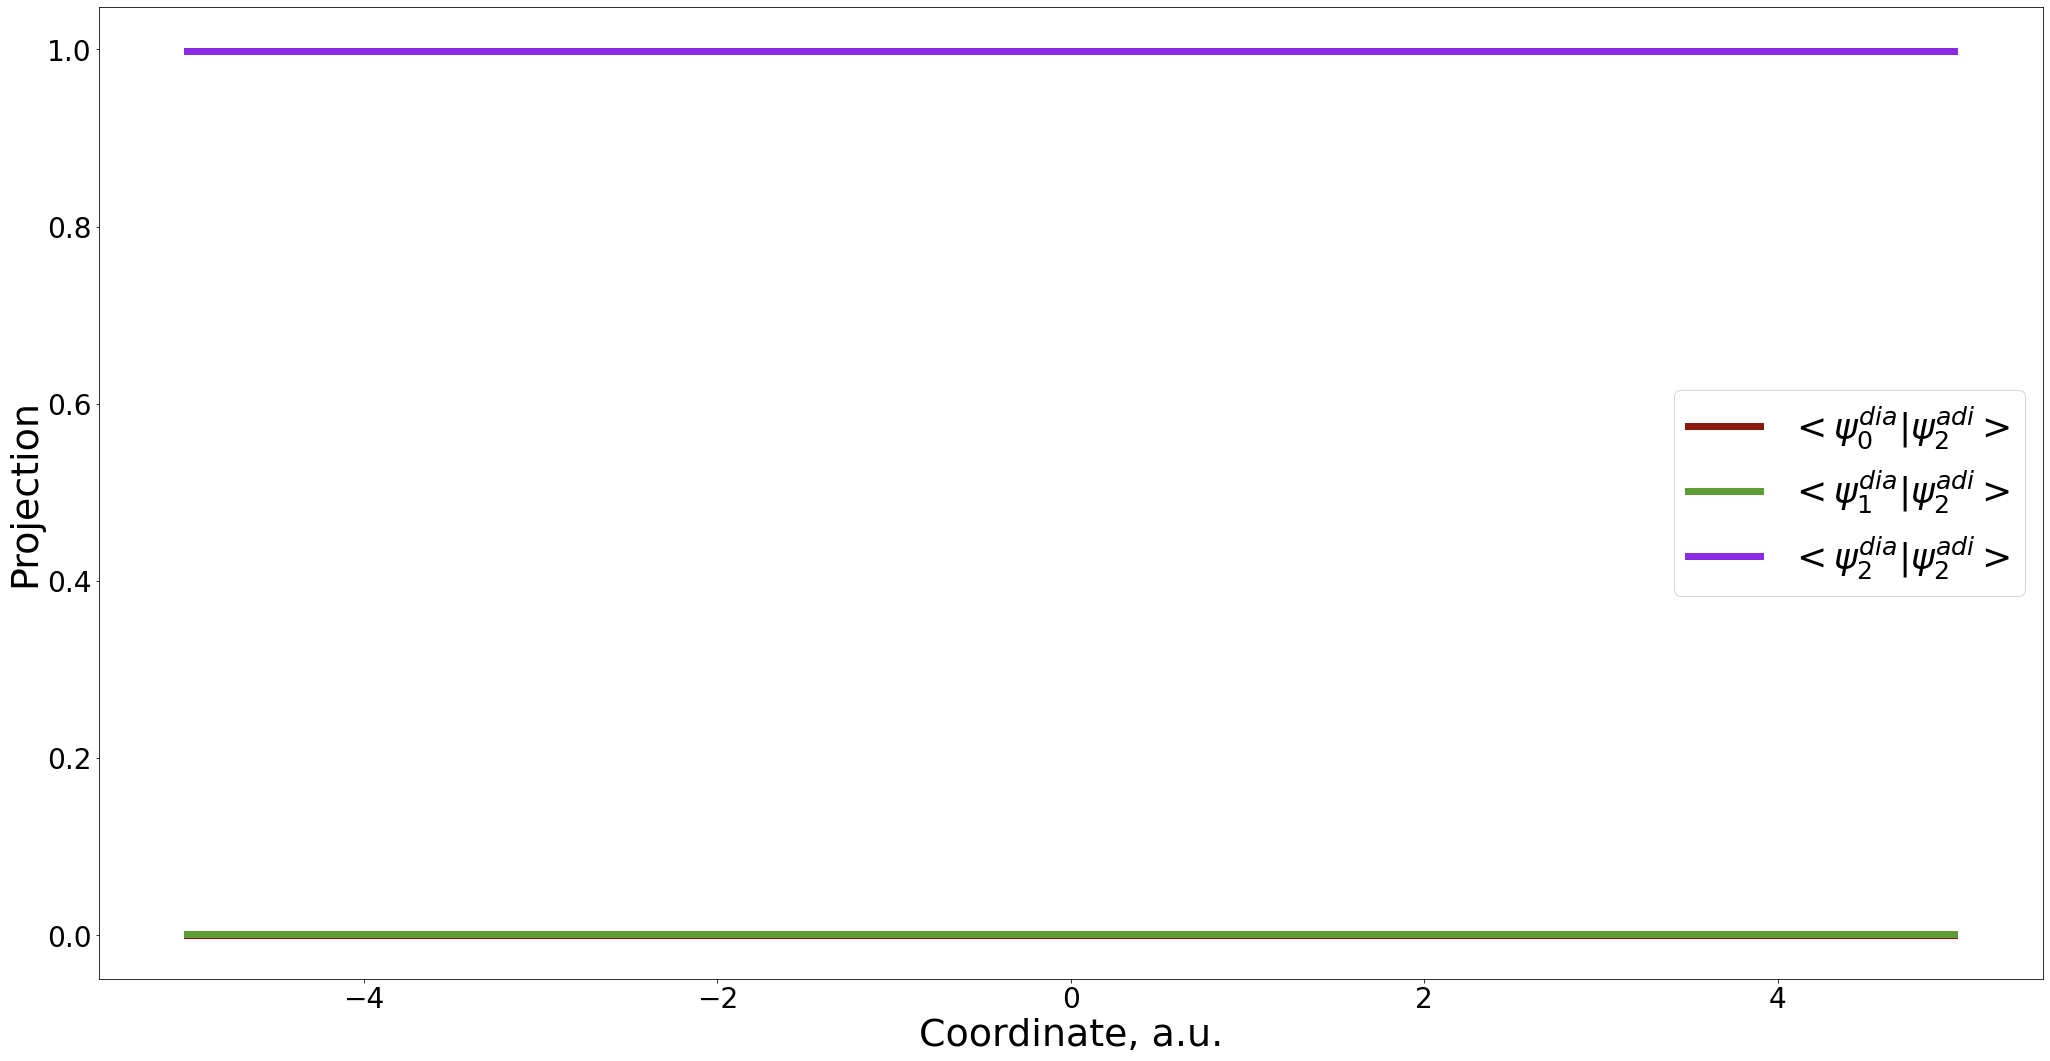

In [5]:
scan_coord = 1
dynamics_plotting.plot_surfaces(Tully.chain_potential, [ model_params ], [0,1,2], -5, 5.0, 0.05, 
                                plot_params, ndof, scan_coord, all_coords)

## 3. Dynamics <a name="dynamics"></a>
[Back to TOC](#TOC)

Let us first define a convenience function that would take care of the initialization of the dynamics and would setup the simulation parameters. This function is also discussed in [this tutorial](), so we are not going to stop here for long.

<a name="generic-recipe"></a><a name="init_nuclear_dyn_var"></a><a name="random"></a>

In [6]:
def run_tsh(common_params, model_params, prefix):
    
    params = dict(common_params)
        
    
    # Random numbers generator object
    rnd = Random()
    
    #============ Initialize dynamical variables ==================
    x0 = params["x0"]
    p0 = params["p0"]
    masses = params["masses"]
    k0 = params["k"]
    ntraj = params["ntraj"]
    nstates = params["nstates"]
    
    # Nuclear
    init_nucl = {"init_type":3, "force_constant":k0, "ntraj":ntraj}
    q, p, iM = tsh_dynamics.init_nuclear_dyn_var(x0, p0, masses, init_nucl, rnd)
    
    # Electronic
    istate = params["istate"]
    istates = []
    for i in range(nstates):
        istates.append(0.0)
    istates[ istate[1] ] = 1.0    
    _init_elec = { "init_type":3, "nstates":nstates, "istates":istates, "rep":istate[0],  "ntraj":ntraj   }

    
    #============= Dynamical variables ==============
    dyn_params = dict(common_params)
    
    # This should update only the properties that aren't defined, but not override the existing values!
    critical_params = [  ]     
    default_params = { "prefix":prefix, "mem_output_level":4 }     
    comn.check_input(dyn_params, default_params, critical_params)
                    
    _model_params = dict(model_params)
    _model_params.update({"model0": model_params["model"] })
    
    start = time.time()                               
    res = tsh_dynamics.generic_recipe(q, p, iM, dyn_params, compute_model, _model_params,_init_elec, rnd)
    end = time.time()    
    print(F"Calculation time = {end - start} seconds")


First, let set up the common parameters for all runs, such as masses and initial position/momenta of the particles, the number of timesteps, initial states, etc.

**IMPORTANT:** The default dynamical parameters are set up for the adiabatic dynamics, not the nonadiabatic TSH, so we need to work it up a bit. Pay attention to these settings:

* ``"tsh_method":0`` - request FSSH calculations
* ``"rep_ham":0`` - our `compute_model` function returns the diabatic Hamiltonian 
* ``"nac_update_method":1`` - we recompute NACs from the derivative coupling vectors and momenta
* ``"hop_acceptance_algo":20`` - accept hops according to the original Tully's formulation
* ``"momenta_rescaling_algo":201`` - momenta changes on successful or frustrated hops is according to the original Tully's formulation

Also note how for this multidimensional case, we need to provide all 5 initial (mean) coordinates,`"x0":[0.0, 0.0, 0.0, 0.0, 0.0]`, (mean) momenta, `"p0":[0.0, 0.0, 0.0, 0.0, 0.0]`, and define the masses for all 5 nuclear DOFs, `"masses":[m, m, m, m, m]`, as well as to define the widths of the distributions for coordinate and momenta sampling in all 5 dimensions, `"k":[k, k, k, k, k],`

Also, since in this tutorials we will be using thermostats, it is convenient to define the thermostat properties here. This doesn't mean we actually use it though.

In [7]:
m, k = 2000.0, 0.001

common_params = { "rep_ham":0, "force_method":1,  "nac_update_method":1,
                  "tsh_method":0, "hop_acceptance_algo":20,   "momenta_rescaling_algo":201,    
                  "nsteps":1000, "dt":10.0, 
                  "ntraj":25, 
                  "x0":[0.0, 0.0, 0.0, 0.0, 0.0], 
                  "p0":[0.0, 0.0, 0.0, 0.0, 0.0], 
                  "masses":[m, m, m, m, m],
                  "k":[k, k, k, k, k],
                  "nstates":3, "istate":[1, 2],
                  "which_adi_states":range(3), "which_dia_states":range(3),
                  "thermostat_params":{ "thermostat_type":"Nose-Hoover", 
                                        "Temperature":300.0, "NHC_size":5,
                                        "nu_therm":0.0045563 
                                      }
                } 

### 3.1. Regular FSSH - in the NVE ensemble <a name="fssh"></a>
[Back to TOC](#TOC)
    
We start with the case the closest to the 1D FSSH. 

* ``"ensemble":0`` - it is done in the NVE ensemble. This is the default setting, but we put it here explicitly to facilitate the comparison with other case.
* ``"quantum_dofs":[0]`` - only the first nuclear DOFs is considered in FSSH procedures. That is, for instance, when we rescale the momenta, we don't rescale the momenta of all other DOFs, just for this one. Also, in computing the NACs, the derivative coupling only along this DOF will be used. All other DOFs, that is 1, 2, 3, and 4 will be treated classically. 
* ``"thermostat_dofs":[]`` - no nuclear DOF is coupled to a thermostat. So, even if we'd set up the ``"ensemble":1``, the dynamics won't be affects. However, the bath energy and the extended energies (total + bath) would be computed, and the extended one won't be conserved. 
* ``"constrained_dofs":[]`` - we don't constrain any DOFs

</a><a name="dyn-partition"></a>

In [8]:
params = dict(common_params)

params.update({ "ensemble":0, 
                "quantum_dofs":[0], 
                "thermostat_dofs":[], 
                "constrained_dofs":[] 
              })

run_tsh(params, model_params, "fssh")

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector'])

Now, lets plot the properties. To do this, we use the built-in convenience function `plot_dynamics`

* ``"what_to_plot": ["energies", "energy_fluctuations", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", "coordinates", "phase_space", "sh_pop", "se_pop_adi", "se_pop_dia", "sh_pop_raw", "se_pop_adi_raw", "se_pop_dia_raw"]`` - this list has only those properties that we want the `plot_dynamics` function to show. In particular, we don't want to see the time-overlaps/projections and basis transforms (listed in the default settings), so we just remove them in this list. Notice how the end of the shown plot says 

      <Figure size 1926x723 with 0 Axes>
     twice, which is where those "deleted" plots would otherwise appear
                                
Some points of interes:

* the total energy is conserved
* the phase space portrait has discontinuities, which are the indications of the surface hopping
* the surface hopping and SE populations are generally consistent with each other
* the raw and dynamically-consistent populations are different, which is an indication that state identity is changing during the dynamics - this is also clearly seen from the adiabatic PES scans (and the projections) along the DOF 0, in the [analysis section](#model_analysis)


<a name="plot_dynamics"></a>

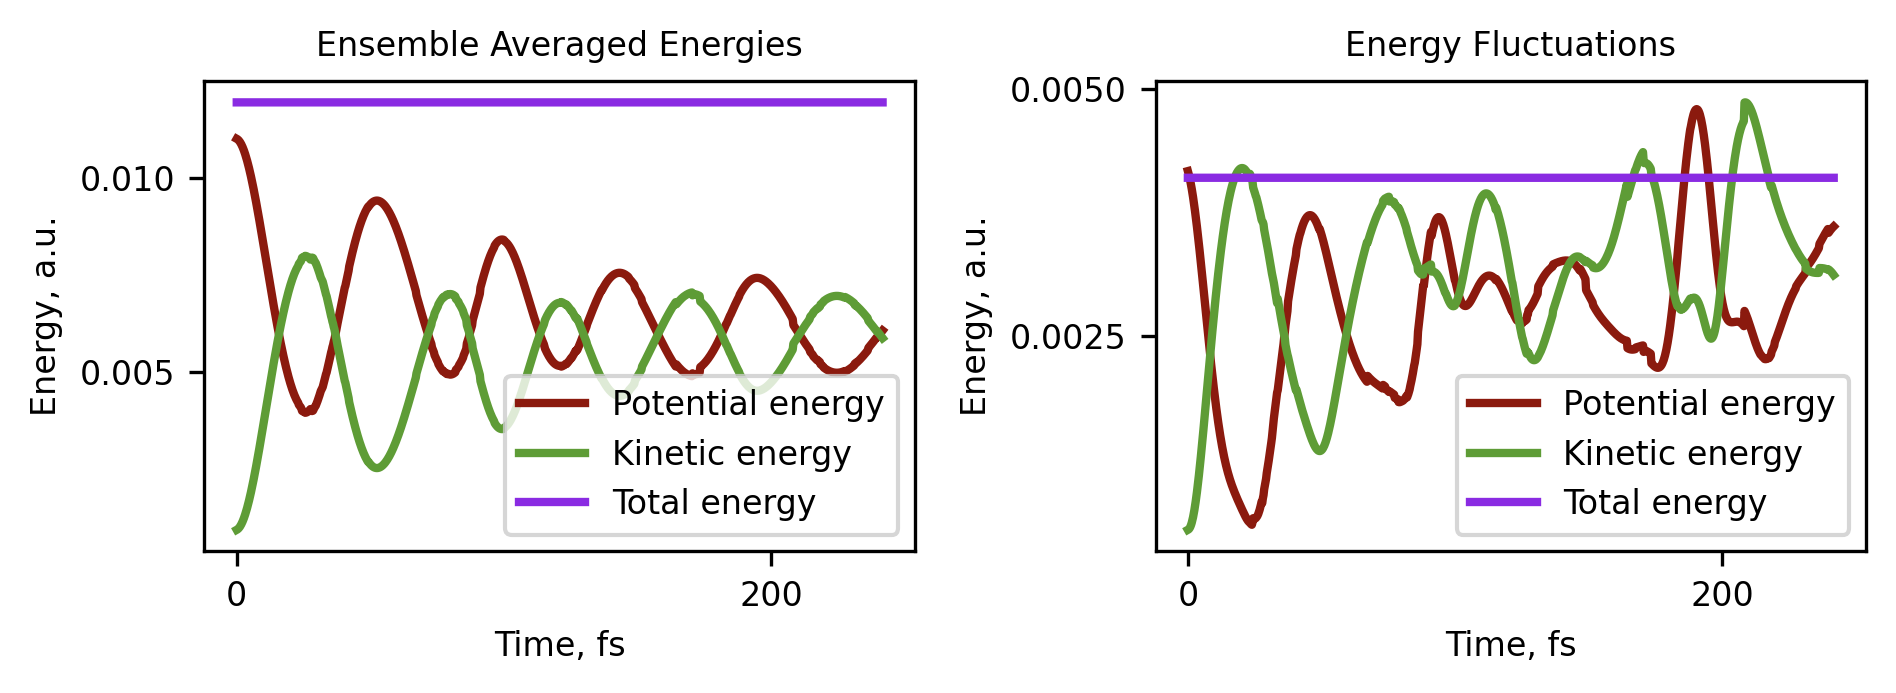

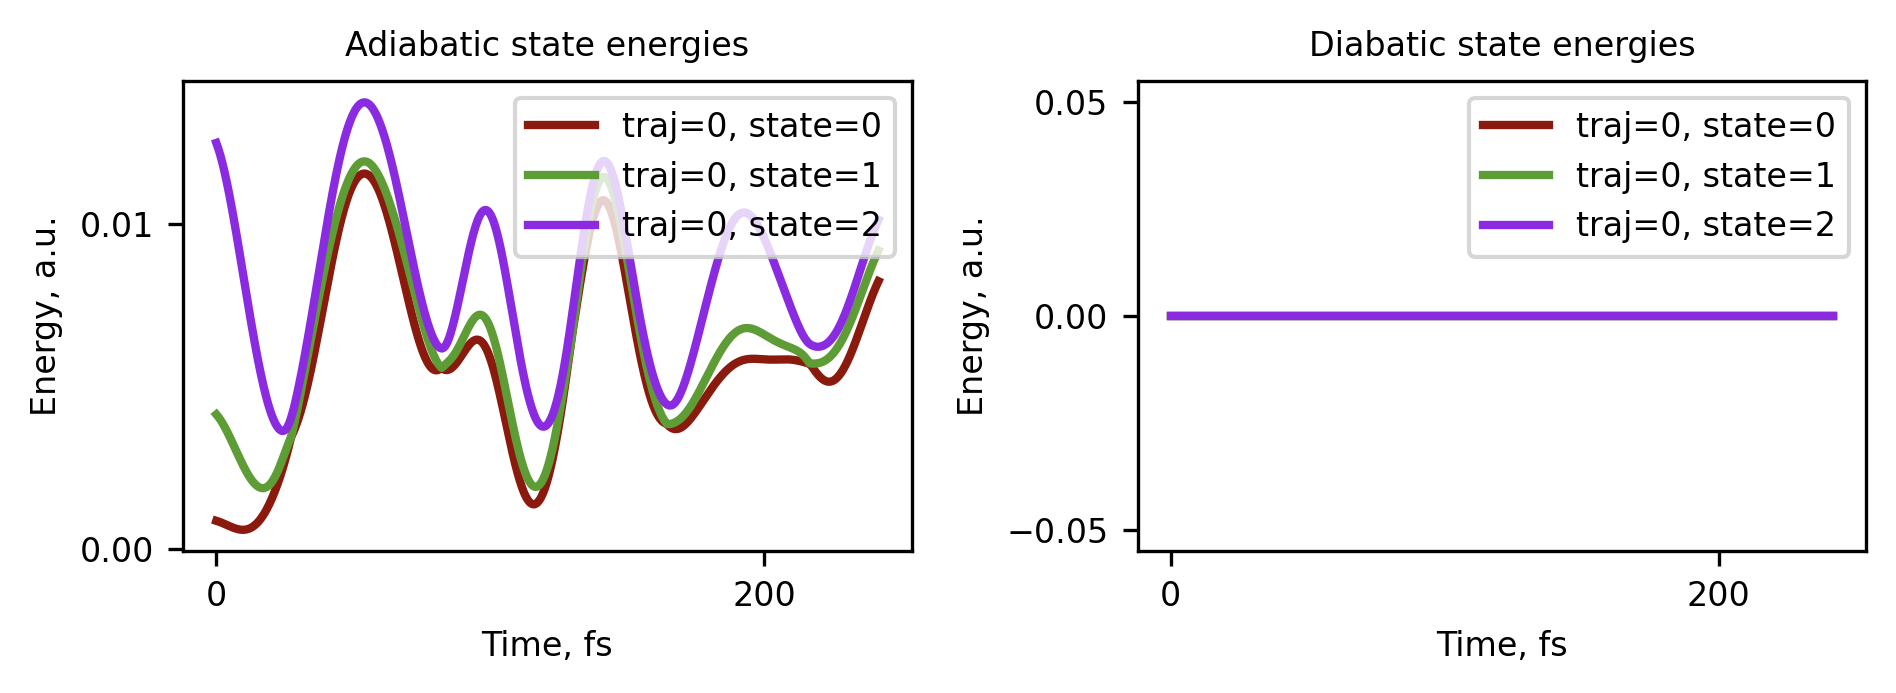

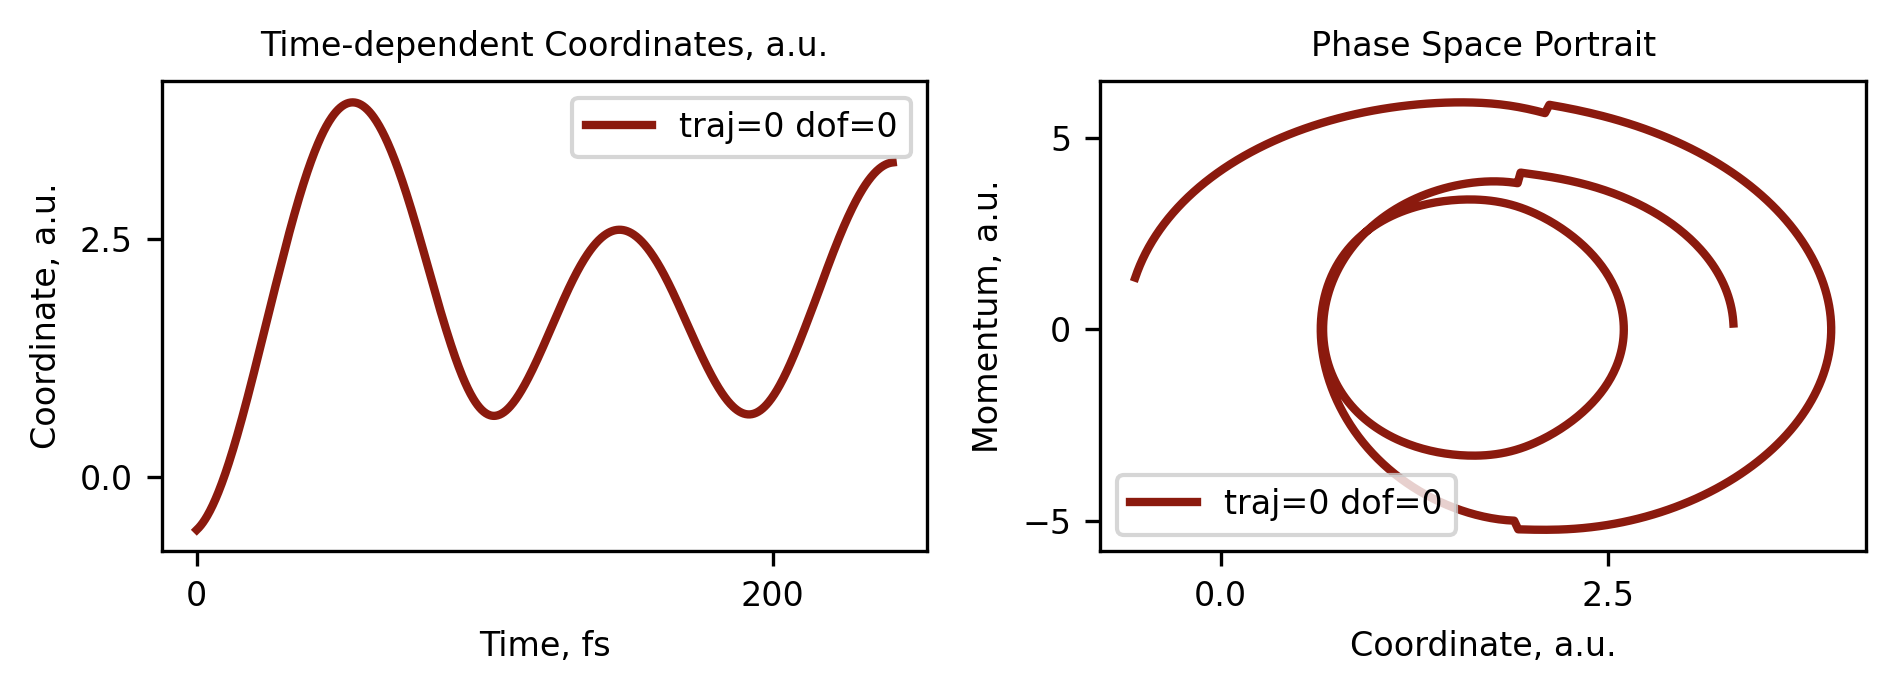

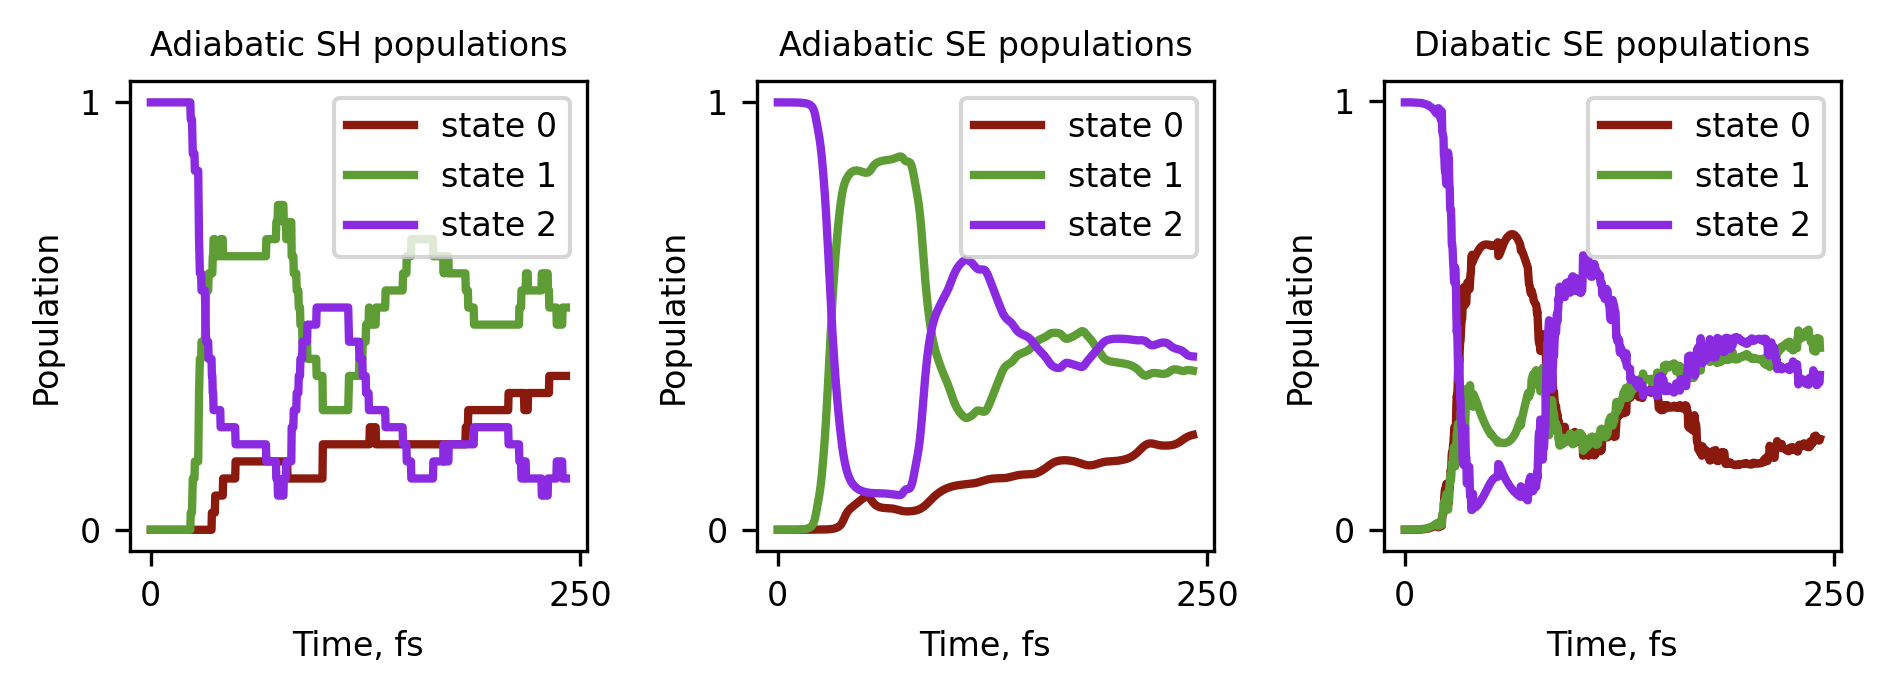

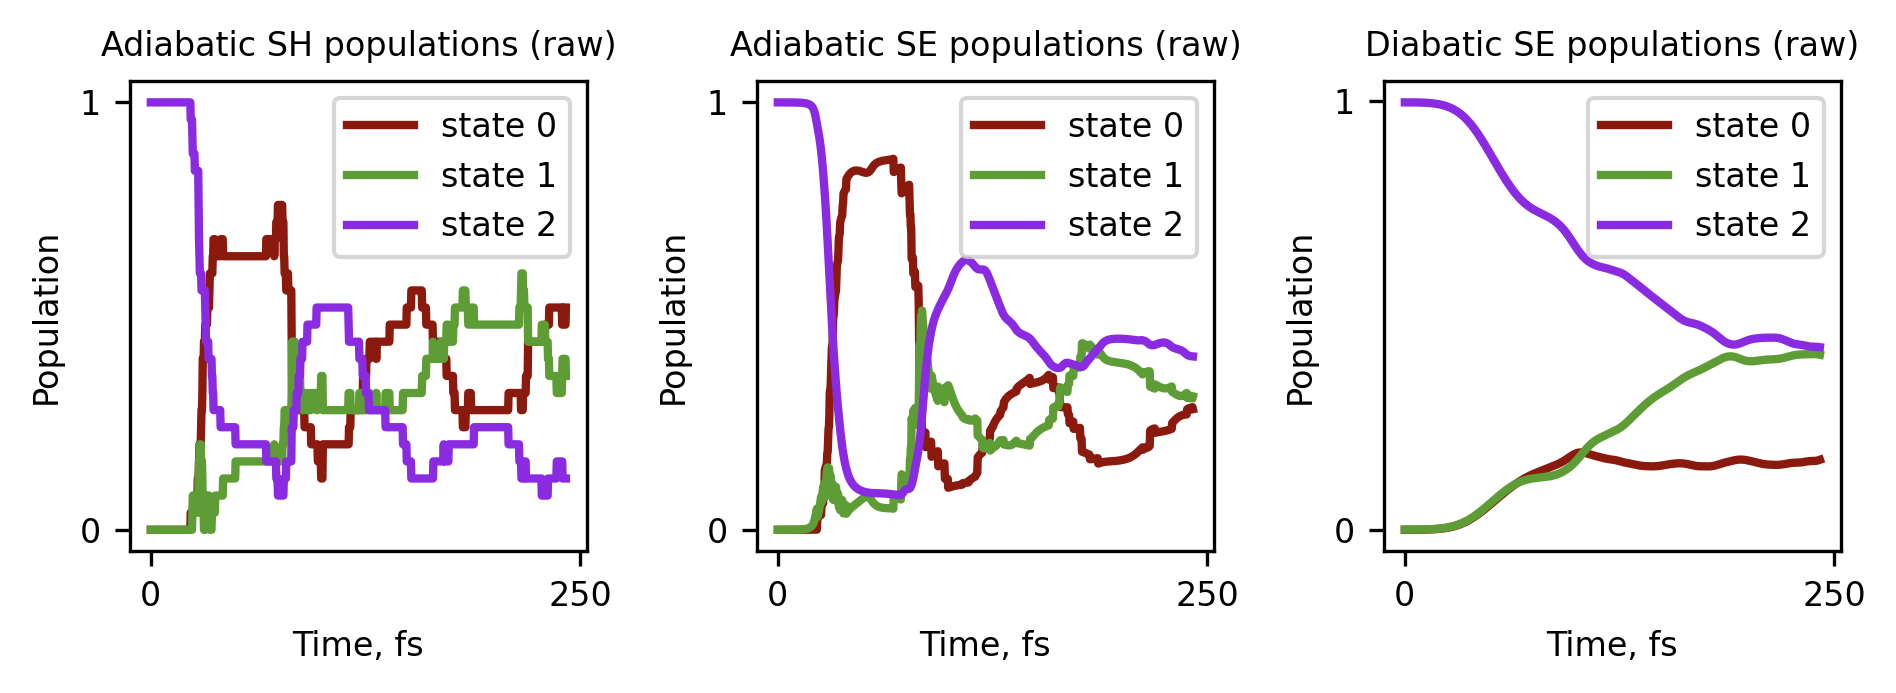

<Figure size 1926x723 with 0 Axes>

<Figure size 1926x723 with 0 Axes>

In [9]:
plot_params = { "prefix":"fssh", "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0],
                "which_adi_states":[0,1,2], "which_dia_states":[0,1,2],
               
                "axes_label_fontsize":(8,8), "legend_fontsize":8, 
                "axes_fontsize":(8,8), "title_fontsize":8,
                "which_energies":["kinetic", "potential", "total"],
                "what_to_plot": ["energies", "energy_fluctuations",
                                 "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham",
                                 "coordinates", "phase_space",
                                 "sh_pop", "se_pop_adi", "se_pop_dia",
                                 "sh_pop_raw", "se_pop_adi_raw", "se_pop_dia_raw"
                                ],
                "frameon":False,                    
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

### 3.2. FSSH in the NVT ensemble: 1 DOF is quantum + 4 DOFs thermostatted <a name="fssh-nvt"></a>
[Back to TOC](#TOC)

<a name="dyn-nvt"></a><a name="dyn-thermostat"></a>
Lets couple all classical DOFs to a thermostat

* ``"ensemble":1`` - it is done in the NVT ensemble ( so the thermostat parameters we set up above will now play a role).
* ``"quantum_dofs":[0]`` - as before, only the first nuclear DOFs is considered in FSSH procedures.  
* ``"thermostat_dofs":[1,2,3,4]`` - all classical DOFs are coupled to the thermostat.  
* ``"constrained_dofs":[]`` - we don't constrain any DOFs

In addition, since later we will want to plot the total energy of the system + bath, we need to include the "E_NHC" keyword to the list of the `properties_to_save`. This keyword is not defined by default. Unfortunately, currently there is no way to just add this keyword, so what we really do is to just override the default list with the list containing one more keyword.

In [10]:
params = dict(common_params)

params.update({ "ensemble":1, 
                "properties_to_save":[ "timestep", "time", "Ekin_ave", "Epot_ave", "Etot_ave", "E_NHC",
                   "dEkin_ave", "dEpot_ave", "dEtot_ave", "states", "SH_pop", "SH_pop_raw",
                   "D_adi", "D_adi_raw", "D_dia", "D_dia_raw", "q", "p", "Cadi", "Cdia", 
                   "hvib_adi", "hvib_dia", "St", "basis_transform", "projector" ], 
                "quantum_dofs":[0], 
                "thermostat_dofs":[1,2,3,4], 
                "constrained_dofs":[] 
              })

run_tsh(params, model_params, "fssh-nvt")

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'pro

Now lets plot the results.

* ``"which_dofs":[0, 1, 2, 3, 4]`` - this time, we want to plot all the nuclear DOFs in the q vs t and phase space portrait
* ``"which_energies":["kinetic", "potential", "total", "extended"]`` - note how we also added the "extended" keyword to the list, so that the subplot with the energies will be also showing the system+bath (extended) energy, in addition to the regular kinetic, potential, and total energies of the system.

Points of interes:
* the total energy is no longer conserved, but the extended energy is - this is expected for the NVT dynamics
* the phase portrait for classical DOFs appear to be more erratic than for the quantum one. This is because they are coupled to the thermostat
* SH and SE populations are still consistent with each other and the state identy changes do occur
* the population dynamics looks pretty similar to the one where we don't have the thermostat

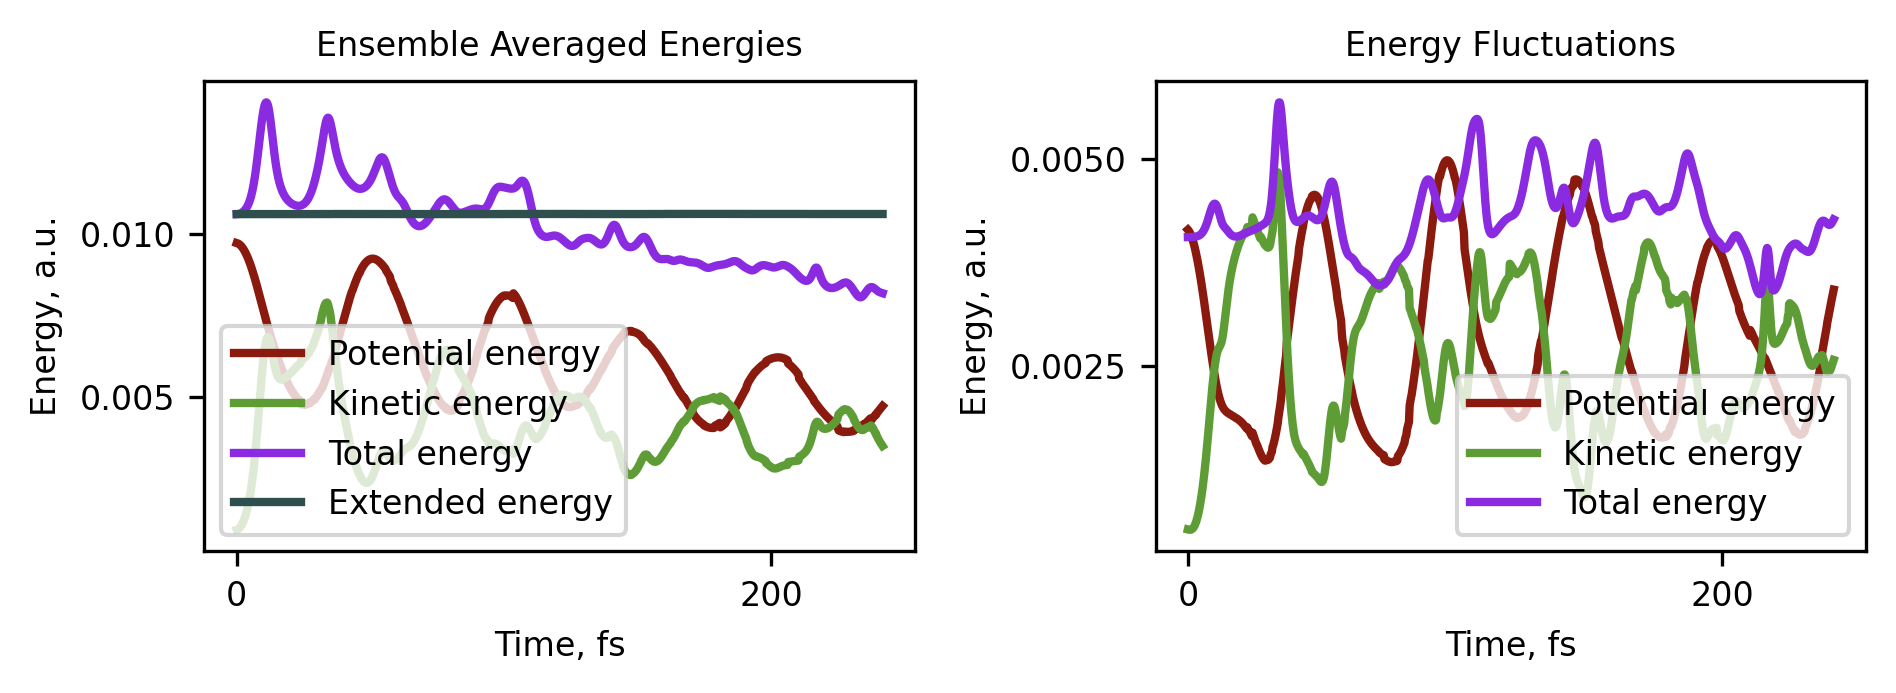

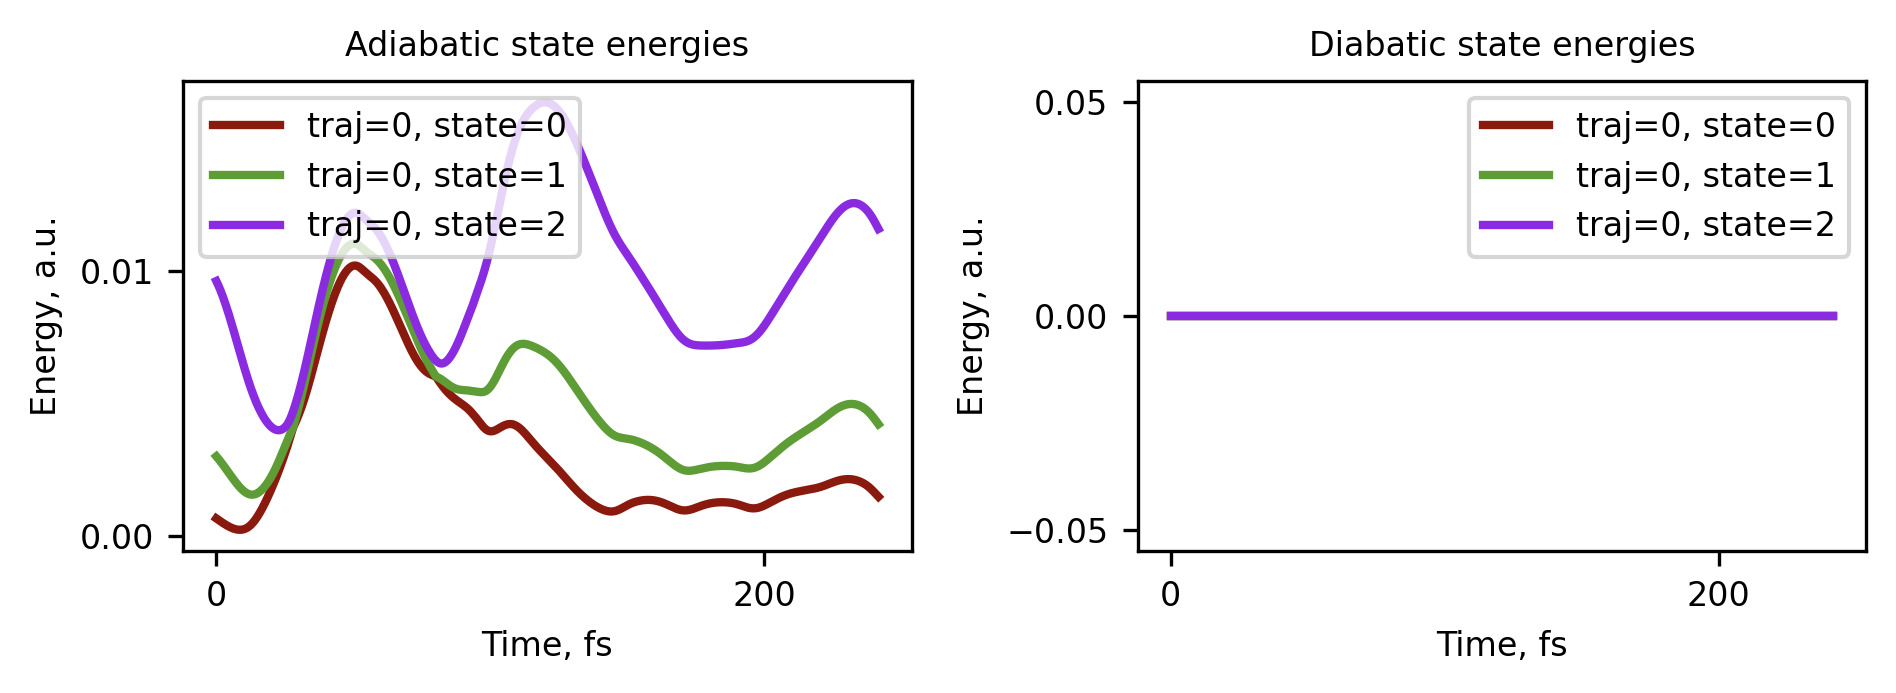

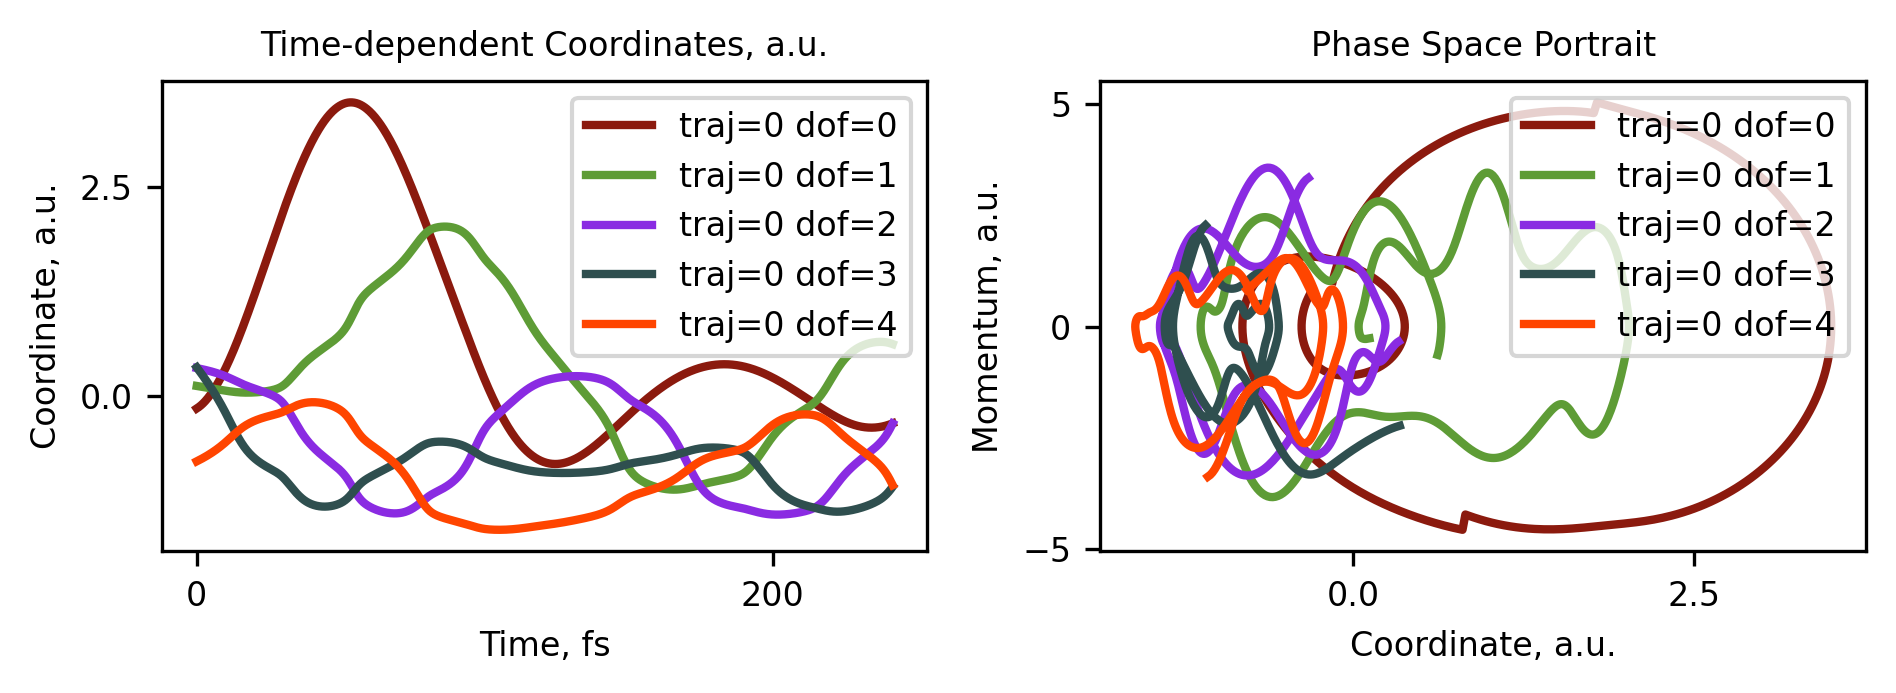

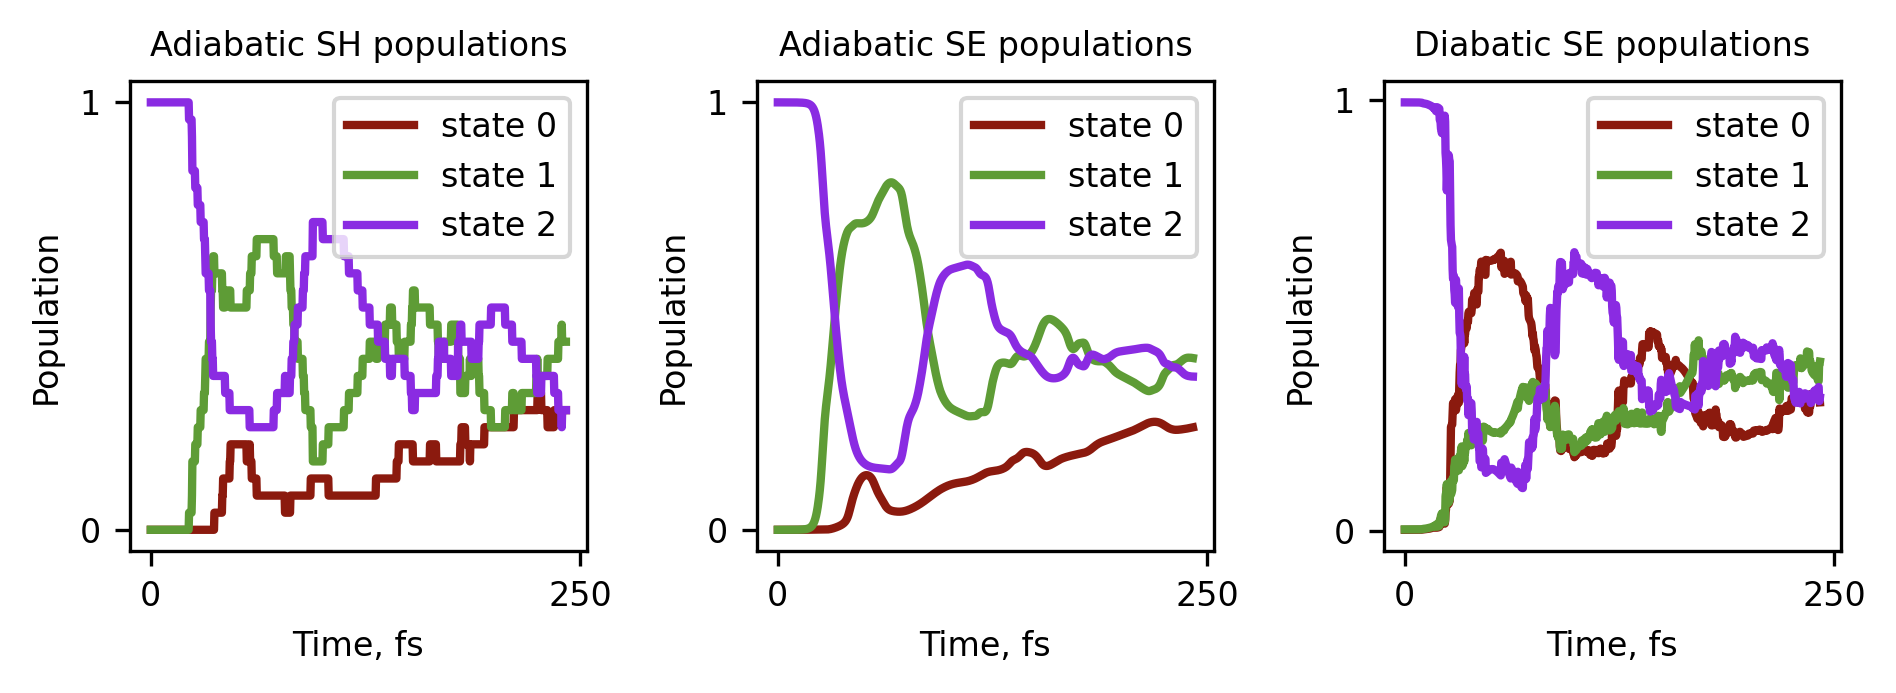

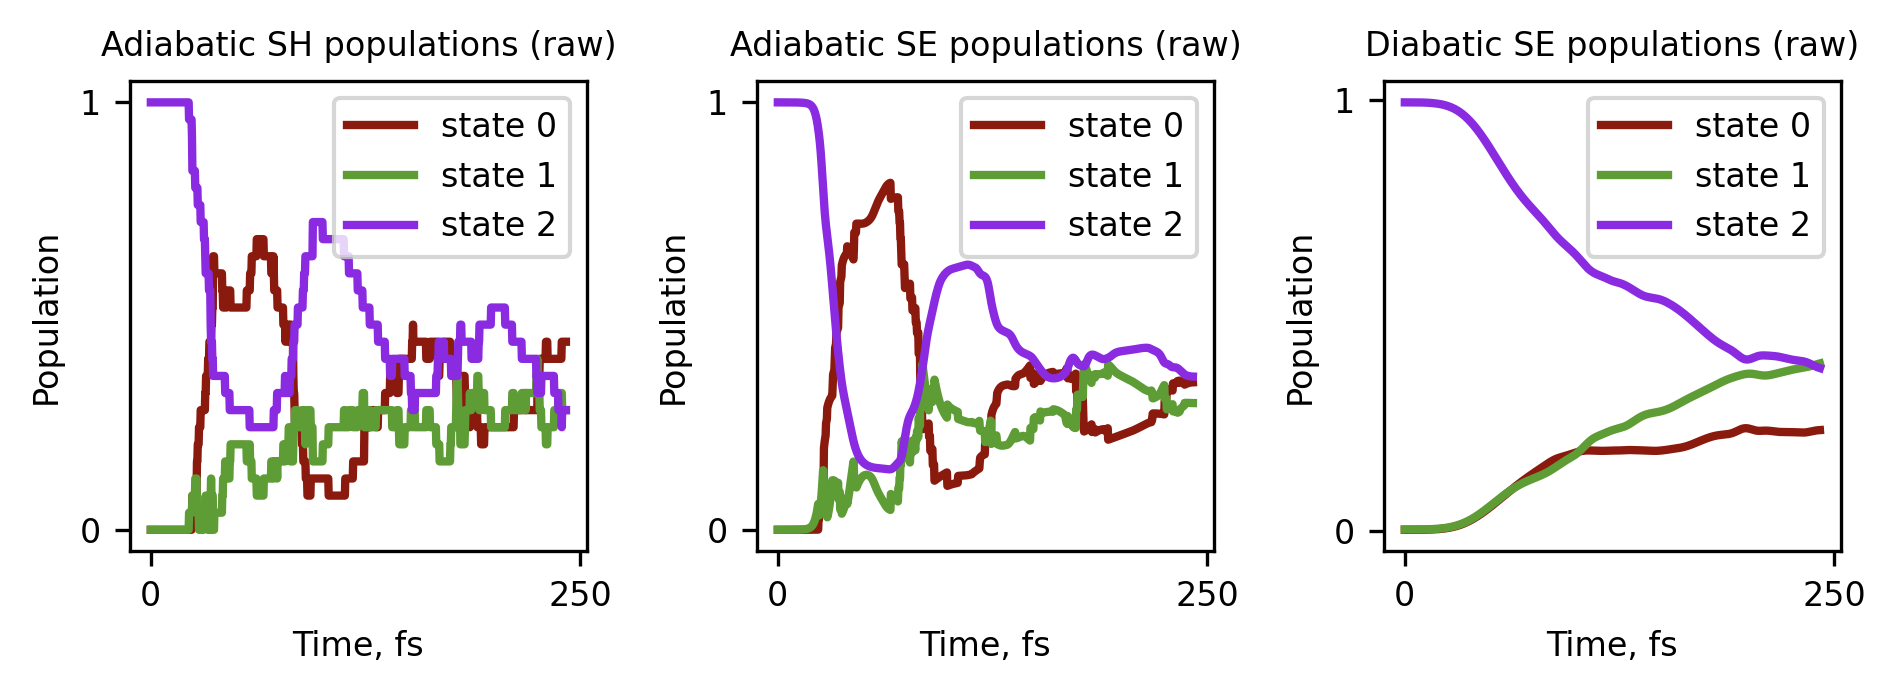

<Figure size 1926x723 with 0 Axes>

<Figure size 1926x723 with 0 Axes>

In [11]:
plot_params = { "prefix":"fssh-nvt", "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0, 1, 2, 3, 4],
                "which_adi_states":[0,1,2], "which_dia_states":[0,1,2],
               
                "axes_label_fontsize":(8,8), "legend_fontsize":8, 
                "axes_fontsize":(8,8), "title_fontsize":8,
                "which_energies":["kinetic", "potential", "total", "extended"],
                "what_to_plot": ["energies", "energy_fluctuations",
                                 "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham",
                                 "coordinates", "phase_space",
                                 "sh_pop", "se_pop_adi", "se_pop_dia",
                                 "sh_pop_raw", "se_pop_adi_raw", "se_pop_dia_raw"
                                ],
                "frameon":False,                    
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

### 3.3. FSSH in the NVT ensemble: 1 quantum DOF + 3 thermostatted DOFs + 1 DOF constrained <a name="fssh-nvt-constraints"></a>
[Back to TOC](#TOC)

<a name="dyn-constrain"></a>
Lets now fix the position of the last particle of the chain (the most distant from the quantum one) and thermostat all other classical DOFs

* ``"thermostat_dofs":[1,2,3]`` - all classical DOFs are coupled to the thermostat.  
* ``"constrained_dofs":[4]`` - we don't constrain any DOFs

In [12]:
params = dict(common_params)

params.update({ "ensemble":1, 
                "properties_to_save":[ "timestep", "time", "Ekin_ave", "Epot_ave", "Etot_ave", "E_NHC",
                   "dEkin_ave", "dEpot_ave", "dEtot_ave", "states", "SH_pop", "SH_pop_raw",
                   "D_adi", "D_adi_raw", "D_dia", "D_dia_raw", "q", "p", "Cadi", "Cdia", 
                   "hvib_adi", "hvib_dia", "St", "basis_transform", "projector" ], 
                "quantum_dofs":[0], 
                "thermostat_dofs":[1,2,3], 
                "constrained_dofs":[4] 
              })

run_tsh(params, model_params, "fssh-nvt-constr")

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'pro

Now, lets plot the results

Points to note:
* the coordinate of the fixed DOFs is constant in the q vs. t plot and appears as a short segment (with the same projection on the coordinate axis) in the phase space diagram
* the population dynamics continues to deviates slightly from the unconstrained case; compared with the original (NVE) dynamics, having the thermostatted DOFs + constrained ones leads to overall notable changes, but the qualitative picture still holds.


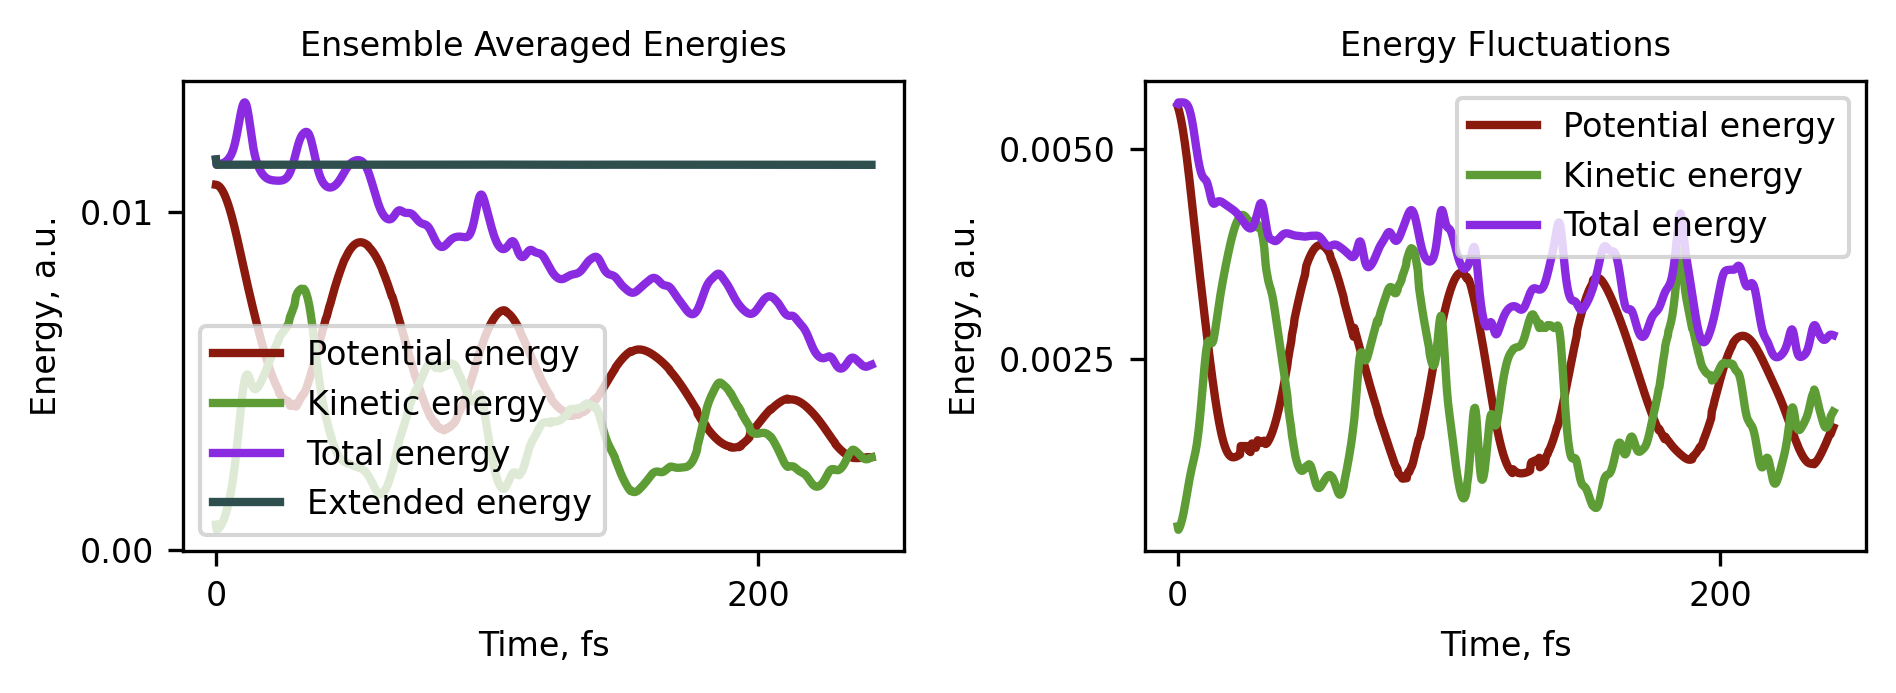

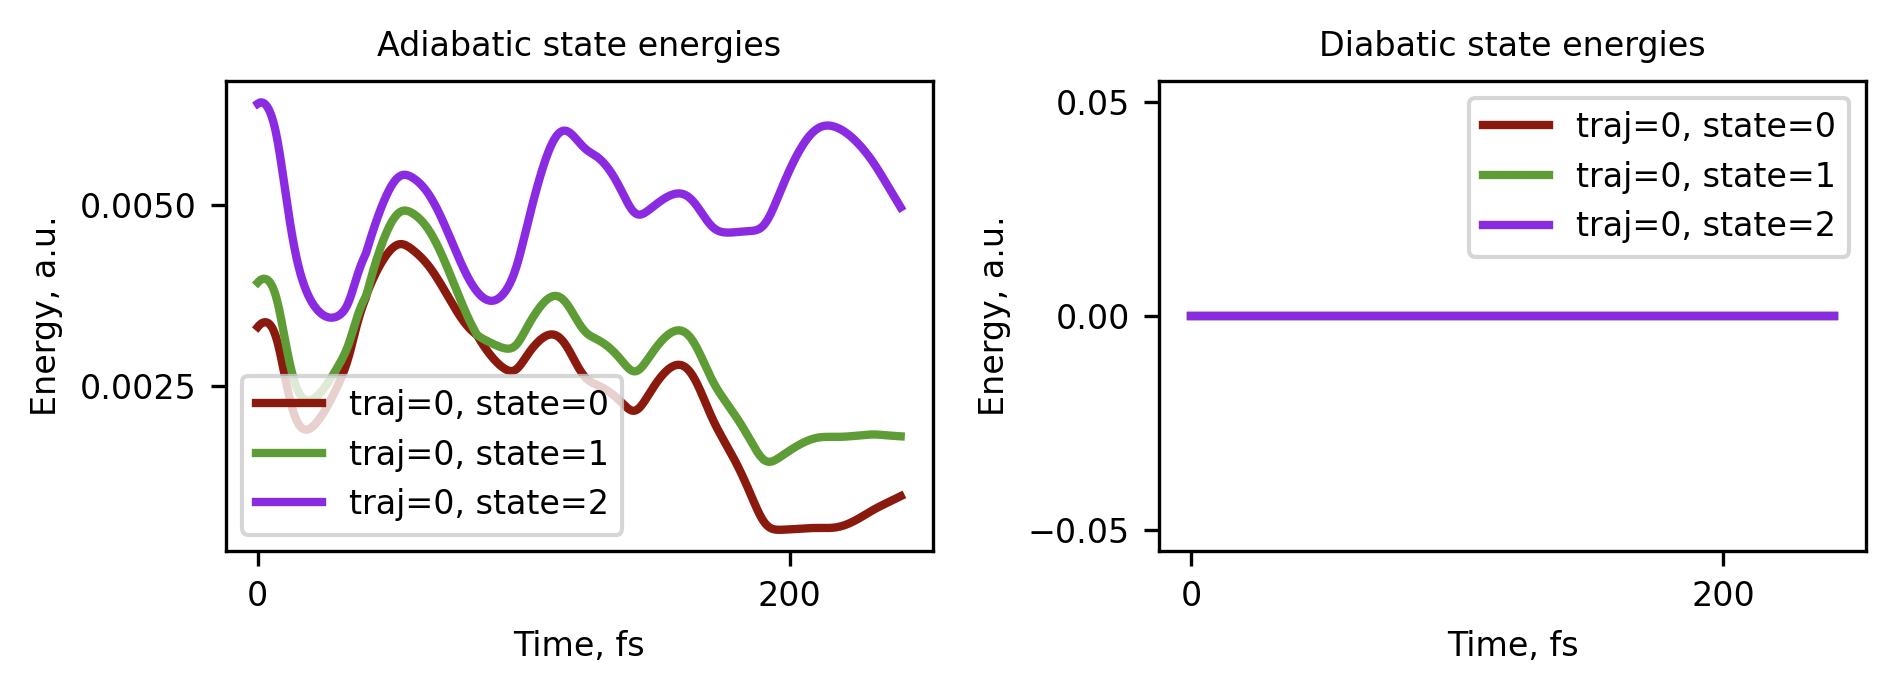

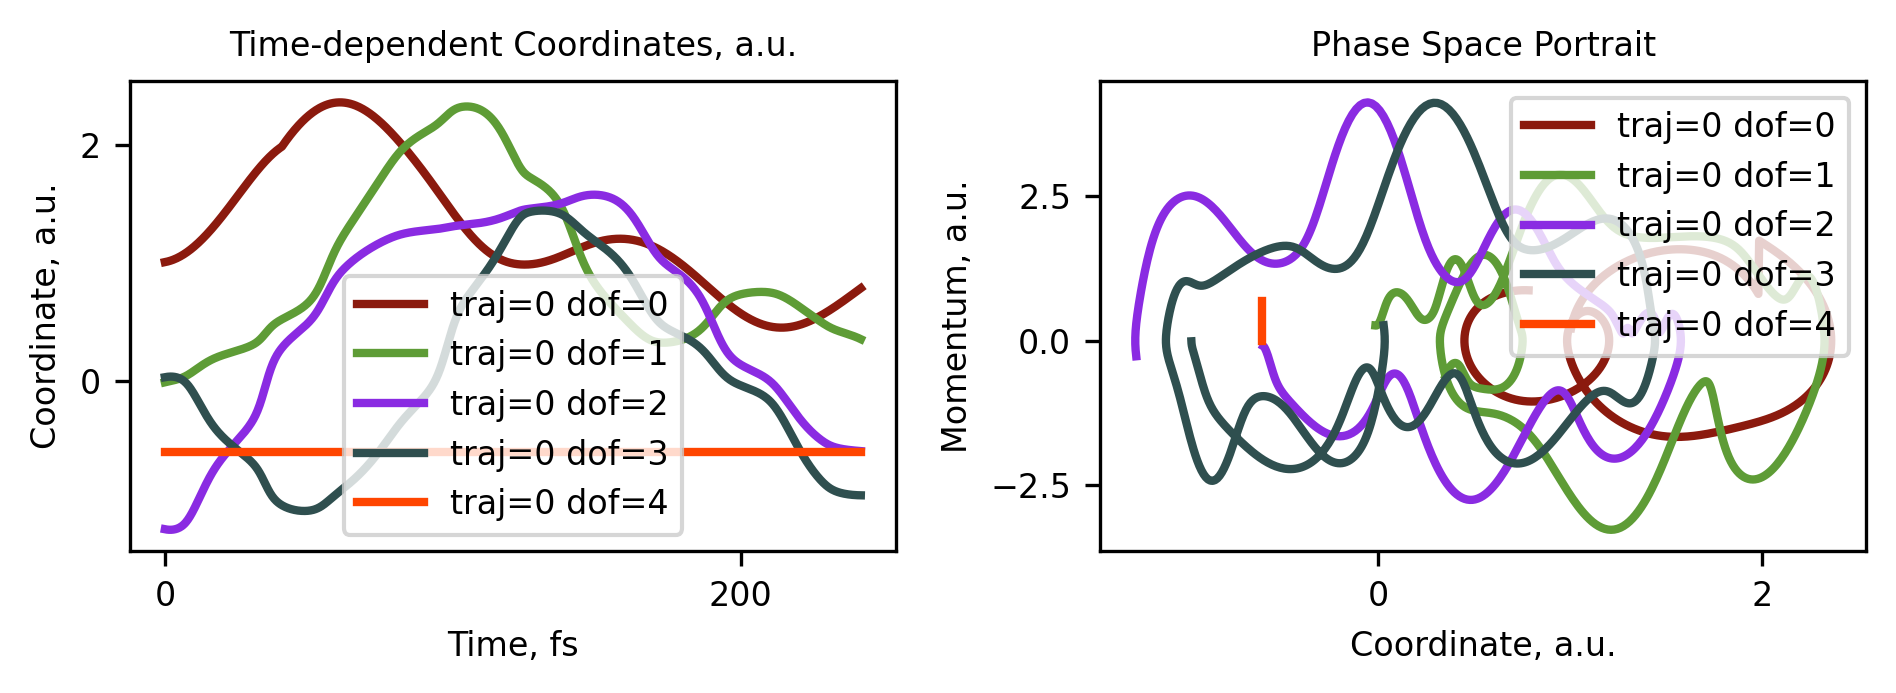

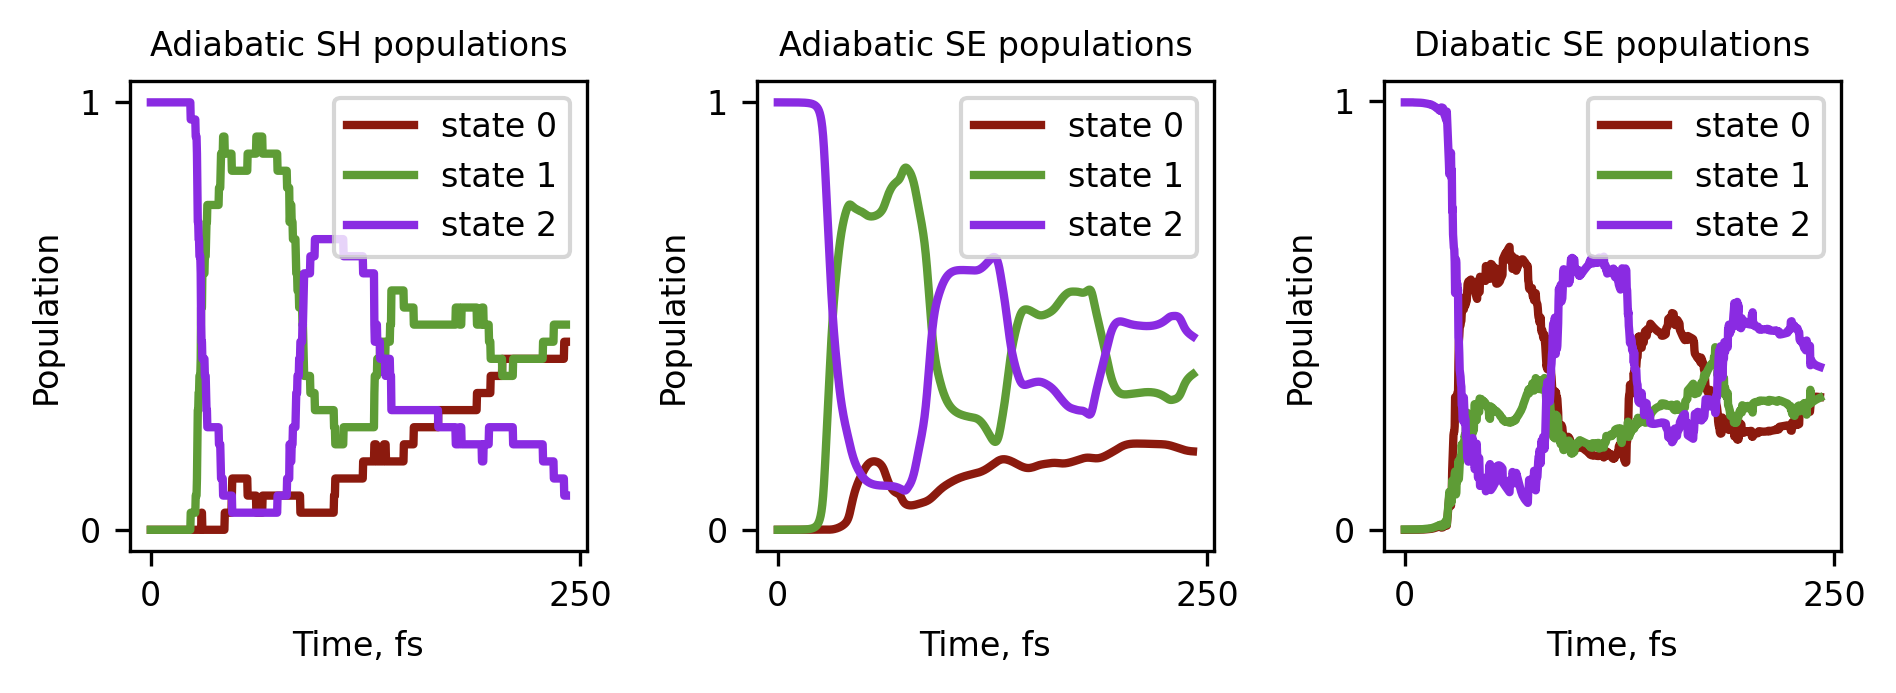

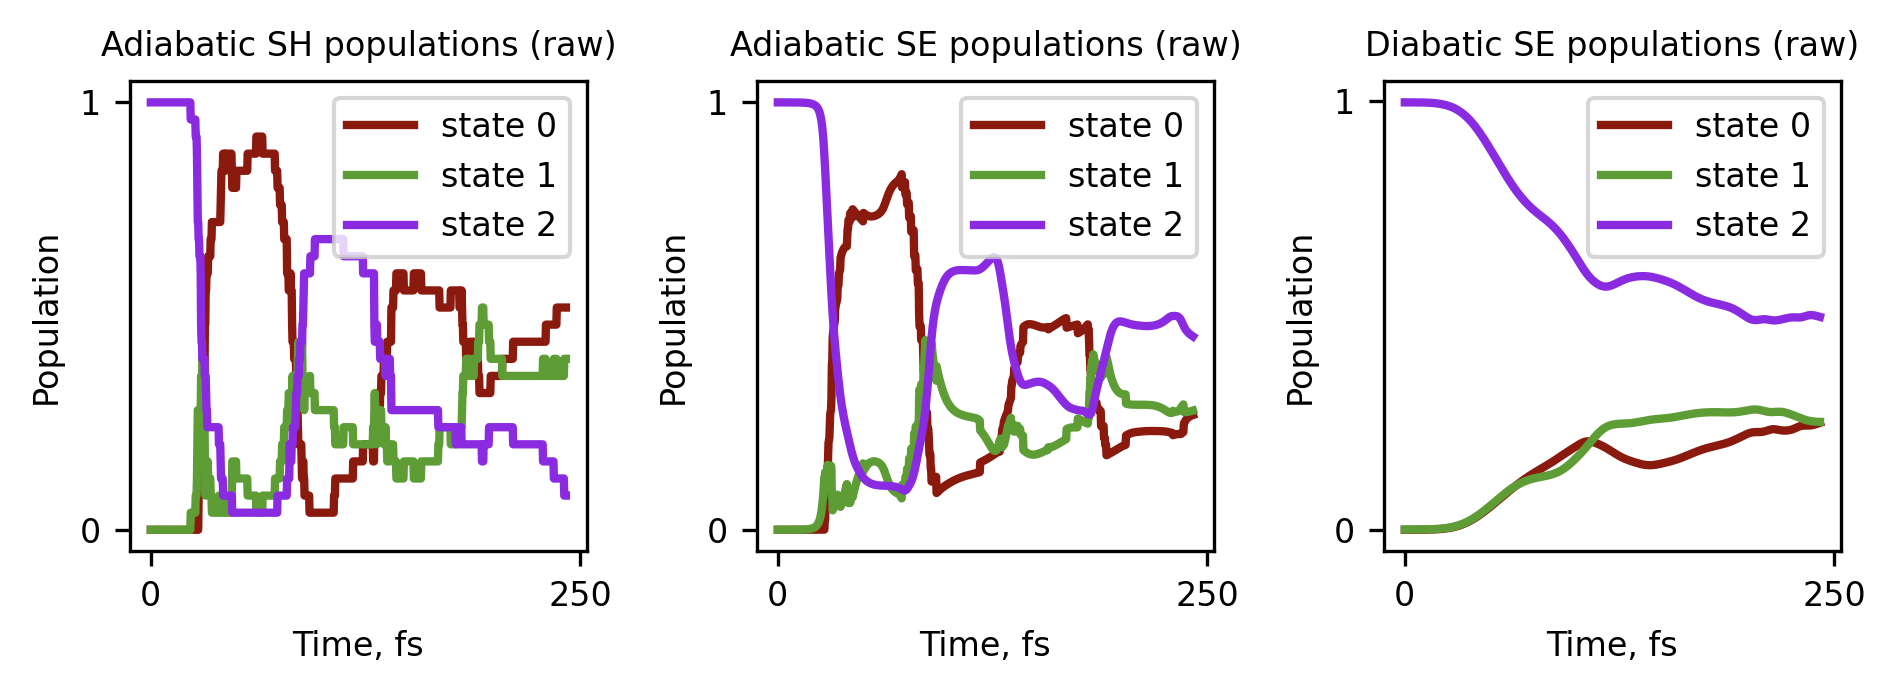

<Figure size 1926x723 with 0 Axes>

<Figure size 1926x723 with 0 Axes>

In [13]:
plot_params = { "prefix":"fssh-nvt-constr", "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0, 1, 2, 3, 4],
                "which_adi_states":[0,1,2], "which_dia_states":[0,1,2],
               
                "axes_label_fontsize":(8,8), "legend_fontsize":8, 
                "axes_fontsize":(8,8), "title_fontsize":8,
                "which_energies":["kinetic", "potential", "total", "extended"],
                "what_to_plot": ["energies", "energy_fluctuations",
                                 "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham",
                                 "coordinates", "phase_space",
                                 "sh_pop", "se_pop_adi", "se_pop_dia",
                                 "sh_pop_raw", "se_pop_adi_raw", "se_pop_dia_raw"
                                ],
                "frameon":False,                    
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

### 3.4. FSSH in the NVE ensemble: all DOFs are quantum<a name="fssh-all-quantum"></a>
[Back to TOC](#TOC)

Finally, lets treat all the nuclear DOFs as quantum (that is affecting the TSH, not like the fully quantum):

* ``"quantum_dofs":[0,1,2,3]`` 

In [14]:
params = dict(common_params)

params.update({ "ensemble":0, 
                "properties_to_save":[ "timestep", "time", "Ekin_ave", "Epot_ave", "Etot_ave",
                   "dEkin_ave", "dEpot_ave", "dEtot_ave", "states", "SH_pop", "SH_pop_raw",
                   "D_adi", "D_adi_raw", "D_dia", "D_dia_raw", "q", "p", "Cadi", "Cdia", 
                   "hvib_adi", "hvib_dia", "St", "basis_transform", "projector" ], 
                "quantum_dofs":[0,1, 2, 3, 4], 
                "thermostat_dofs":[], 
                "constrained_dofs":[] 
              })

run_tsh(params, model_params, "fssh-all-quantum")

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector'])

Points to note:

* Again, the total energy is now the conserved property (we do the NVE ensemble now, remember)

* Although the initial population dynamics is similar to the very first example, we can see a clear faster dampening of the coherent oscillations at longer times 

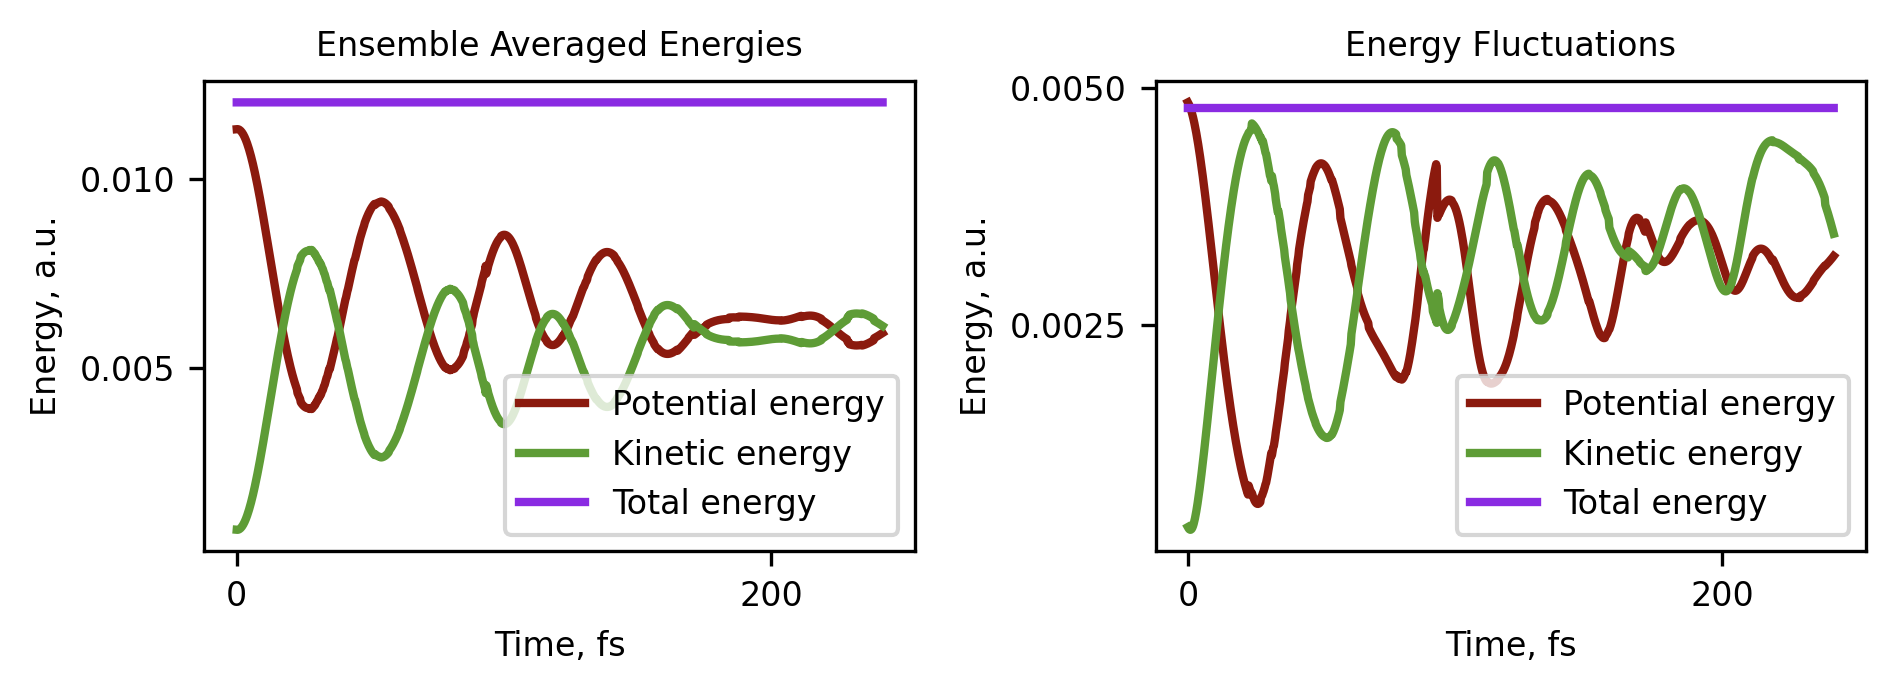

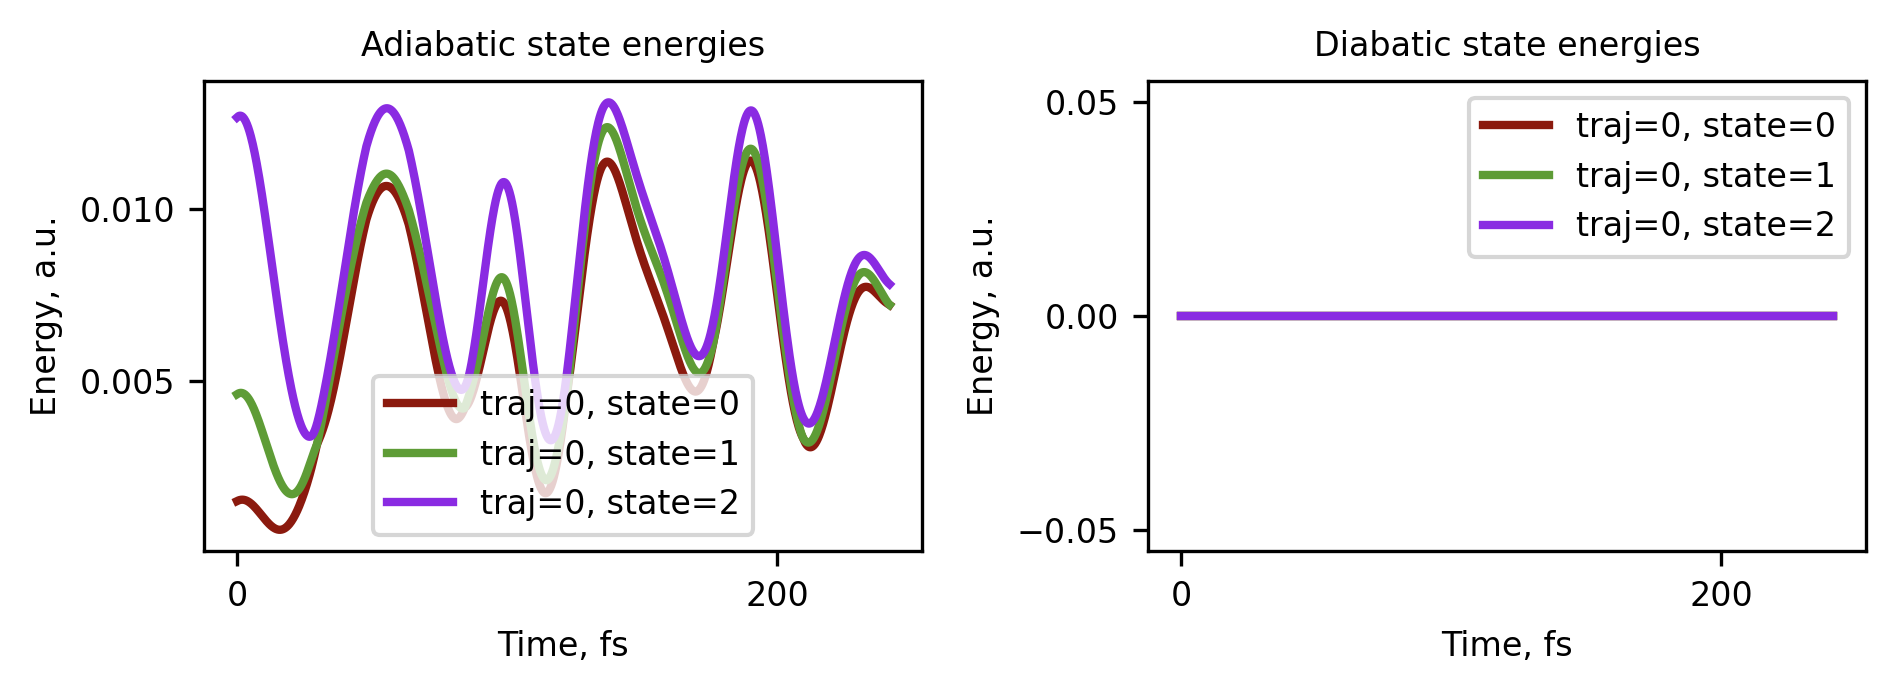

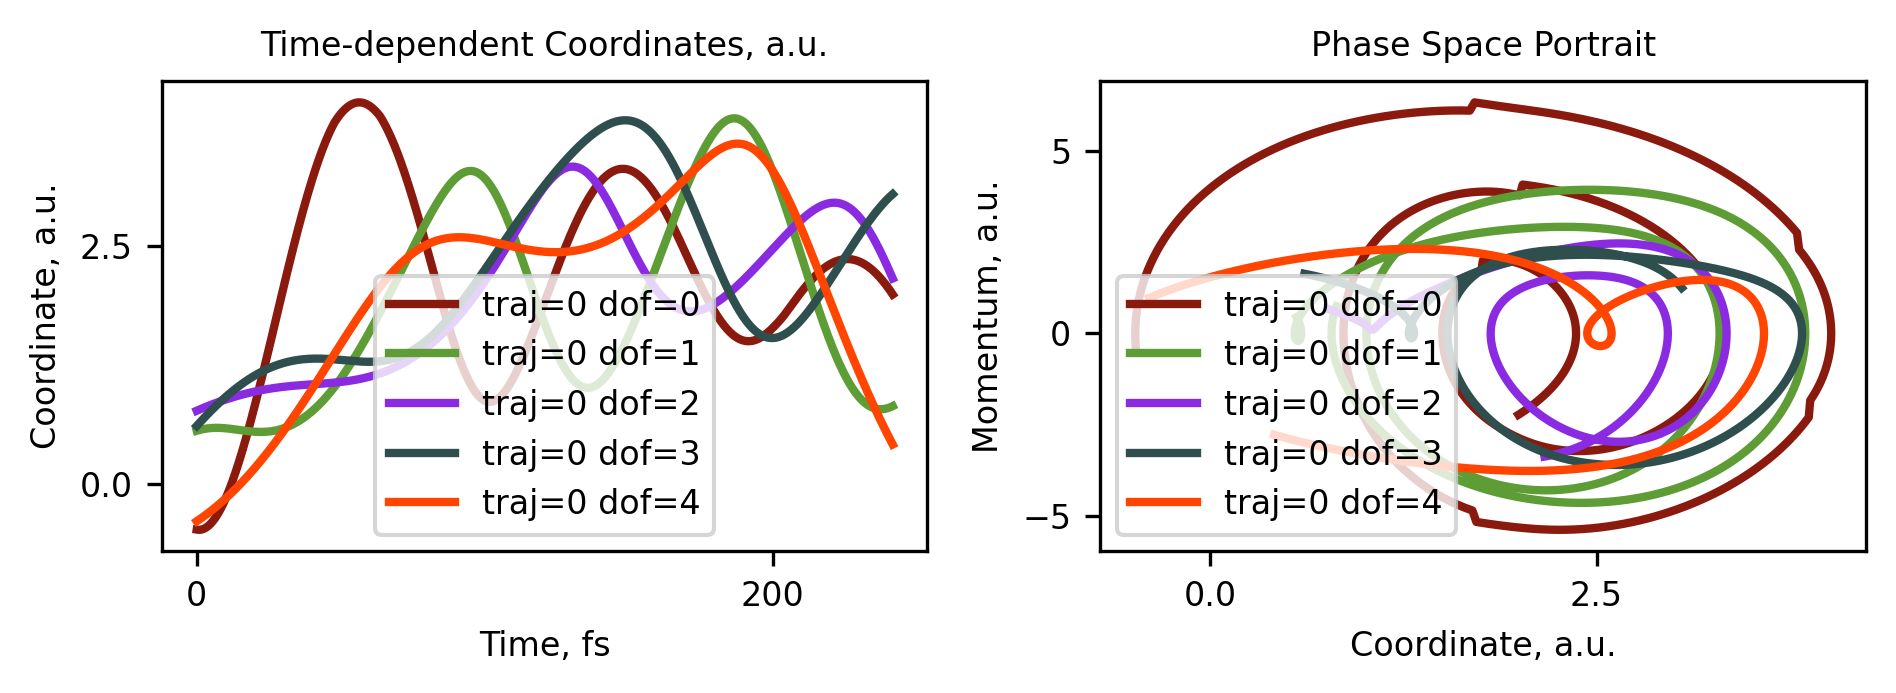

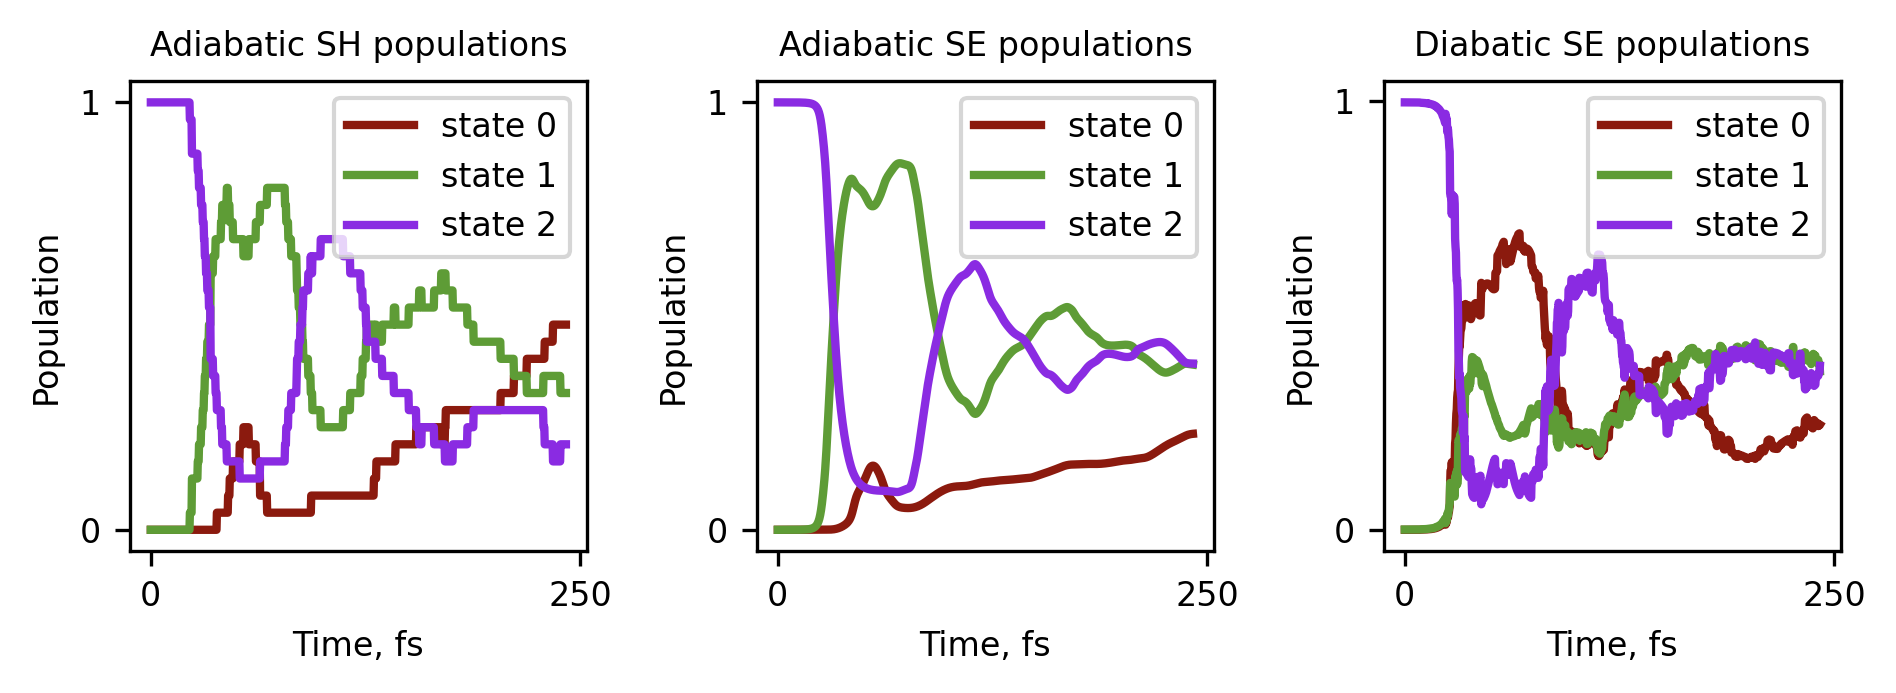

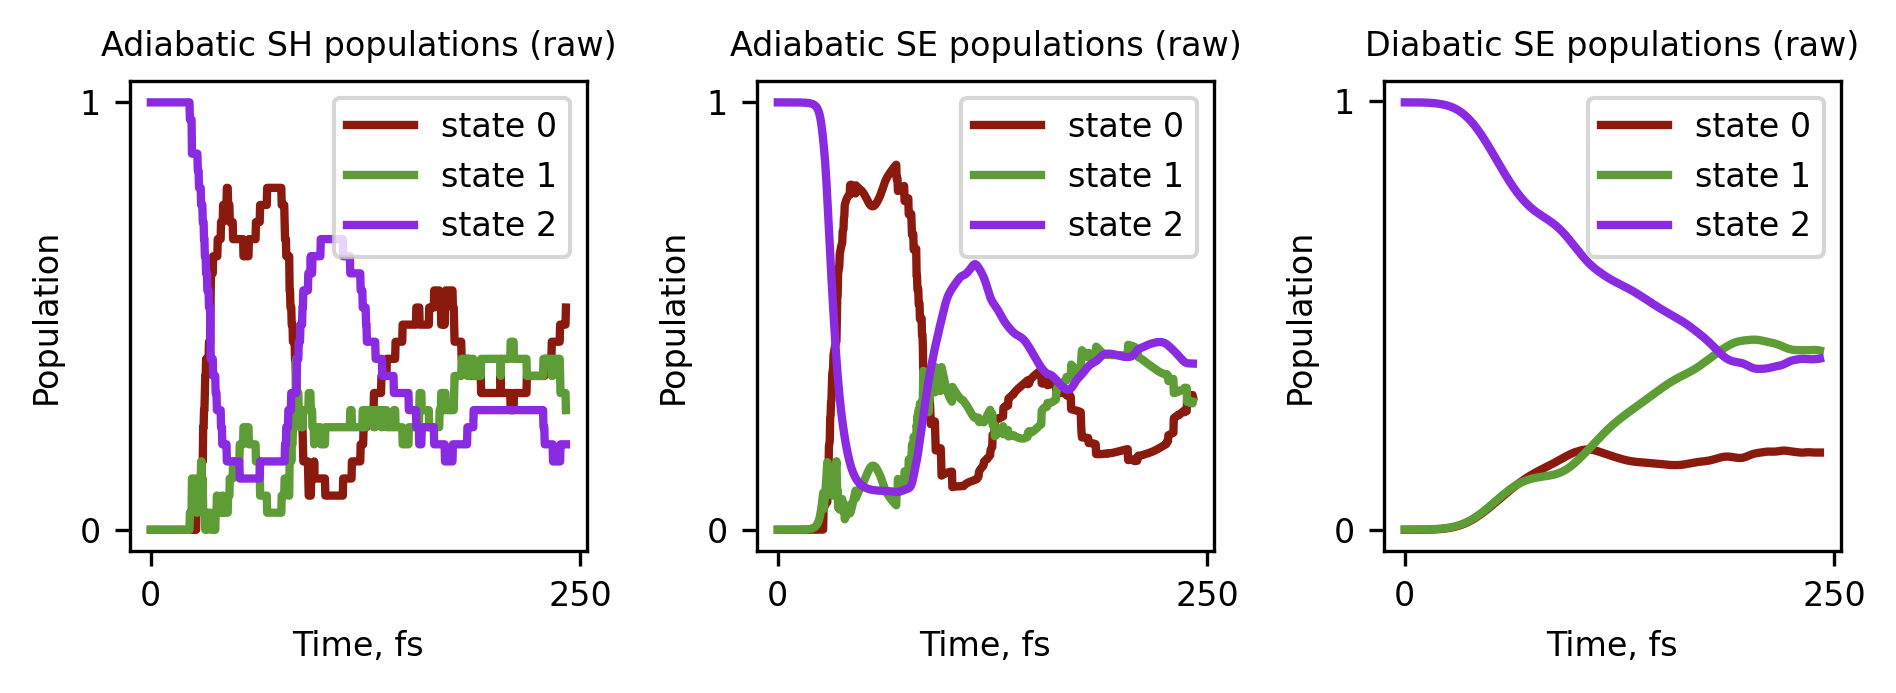

<Figure size 1926x723 with 0 Axes>

<Figure size 1926x723 with 0 Axes>

In [15]:
plot_params = { "prefix":"fssh-all-quantum", "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0, 1, 2, 3, 4],
                "which_adi_states":[0,1,2], "which_dia_states":[0,1,2],
               
                "axes_label_fontsize":(8,8), "legend_fontsize":8, 
                "axes_fontsize":(8,8), "title_fontsize":8,
                "which_energies":["kinetic", "potential", "total"],
                "what_to_plot": ["energies", "energy_fluctuations",
                                 "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham",
                                 "coordinates", "phase_space",
                                 "sh_pop", "se_pop_adi", "se_pop_dia",
                                 "sh_pop_raw", "se_pop_adi_raw", "se_pop_dia_raw"
                                ],
                "frameon":False,                    
              }

tsh_dynamics_plot.plot_dynamics(plot_params)